In [12]:
# -*- coding: utf-8 -*-
"""vrp_dqn.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1iothquIlGtKKte5KIxO-YCKzXnZGjbK-
"""
# !pip install tsplib95

from tqdm import tqdm
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from matplotlib import style
import tsplib95
import networkx as nx
import pickle

import time
import math
import re
import random
import copy

import tensorflow
if tensorflow.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tensorflow.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

from tensorflow.python.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
from tensorflow.python.keras import Sequential
# from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras.optimizers import Adam
from collections import deque

import io # to save the image

Default GPU Device: /device:GPU:0


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [13]:
# https://stackoverflow.com/questions/57301698/how-to-change-a-learning-rate-for-adam-in-tf2https://stackoverflow.com/questions/57301698/how-to-change-a-learning-rate-for-adam-in-tf2
class LearningRateReducerCb(tensorflow.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        # old_lr = self.model.optimizer.lr.read_value()
        # new_lr = old_lr * 0.99
        new_lr = 0.1
        # print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
        self.model.optimizer.lr.assign(new_lr)

In [14]:
# 6. Define the movement restriction of the truck.
class Truck:
    def __init__(self, capacity, id, color):
        self.id = id
        self.color = color
        self.path = [] #this has the list of nodes it has visited
        self.max_truck_capacity = copy.deepcopy(capacity) #the max capacity
        self.capacity = copy.deepcopy(capacity)
        #self.visit_depo()
        self.prev_node = None
        self.node = 1 #starts from the depo

    def action(self, choice):
        # the number of choice of actions are the number of nodes-1
        # the choice to be taken depends on the demands - penalty based
        # the choice number is the same as the node number
        # it is not a choice if the demand is 0 - changing this to penalty
        #!! Want the system to learn instead
        # if self.capacity == 0:
        #     self.visit_depo()
        self.move(choice)

    def move(self, to_node_value):
        # node_list_copy = copy.deepcopy(node_list)
        # node_list_copy.remove(1)
        # select a random node to go to
        #if not to_node_value: #to_node_value is False by default
        #    to_node_value = random.choice(self.node_list)
        if to_node_value == 1:
            self.visit_depo()
        self.prev_node = self.node
        self.node = to_node_value
        self.path.append(to_node_value)
        # when invoked update the demand of the node
        # update the demand of the node

    def visit_depo(self):
        self.prev_node = self.node
        self.node = 1 #here it is 1
        self.capacity = copy.deepcopy(self.max_truck_capacity) #truck capacity reset
        self.path.append(1)
    
    #def path(self, node_value):
    #    self.path.append(node_value)

    # def get_node(self):
    #     return self.node

    
    # def get_capacity(self):
    #     return self.capacity


In [52]:
class VRPEnvironment:
    # environment related constants
    #https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.figure.html
    #observation_space = (640,480,3)
    # observation_space = (100,100,3)
    observation_space = (10,10,3)
    # penalty and rewards
    non_positive_capacity_penalty = 100
    zero_demand_penalty = 100 #truck goes to a zero demand node - except 1
    # ignore the failing task penalty as the episode will end only when...
    # all the demands are satisfied i.e. task will always be success...
    # The penalty of the achievement needs to go down.
    failing_task_penalty = 100 #trucks fail to complete the task
    completion_reward = 5000 #trucks complete the task
    hopping_incentive_penalty = 1000
    # visit_correct_node_reward = 100
    # exploration settings
    permitted_path_length = 30
    epsilon = 1
    epsilon_decay = 0.999#changing this from 0.999
    min_epsilon = 0.001 #0.001
    no_of_episodes = 30_000
    # from 0 to 0.5 difference is small so using 1 first
    truck_colors = {
        1:(0,0,1),
        2:(0,1,0),
        3:(1,0,0),
        4:(0,0.5,0.5),
        5:(0.5,0,0.5),
        6:(0.5,0.5,0),
        7:(0.5,0.5,0.5),
        8:(0.5,0.5,1),
        9:(0.5,1,0.5),
        10:(1,0.5,0.5)
    }
    return_images = True
    image_size = 100

    def __init__(self):
        # 1. Extract the tsplib95 file problem
        # self.problem = tsplib95.load_problem('/content/drive/My Drive/HW Assignments/Sem 2/ADBI/Vrp-All/A/A-n32-k5.vrp')
        # self.problem = tsplib95.load_problem('/content/drive/My Drive/HW Assignments/Sem 2/ADBI/Vrp-All/_singleTruck/A-n32-k5_2.vrp')
        self.problem = tsplib95.load_problem('Vrp-All/_singleTruck/A-n32-k5_2.vrp')        
        # 2. Create a networkx graph out of the problem. //will be plotting this
        self.nx_graph = self.problem.get_graph()
        self.edge_list = list(self.problem.get_edges()) #[(,)]
        self.node_positions = self.problem.node_coords #dict
        # the list of nodes
        self.node_list = list(self.problem.get_nodes())
        self.action_space = len(self.node_list) #the number of choices including staying put
        # the depot location
        self.depot_location = 1
        # assigning the default color of the nodes to be black
        # node_color_values = [(0,0,0) for i in range(len(node_list))]
        # reseting the environment when initialized
        self.reset_environment()
        
    def reset_environment(self):
        # creating the Trucks
        # 4. Extract the necessary data about the trucks. //no of trucks, depot_section, capacity
        self.node_demands = copy.deepcopy(self.problem.demands)
        truck_capacity = copy.deepcopy(self.problem.capacity)
        # trying hardcoding for now
        self.truck = Truck(truck_capacity, 1, self.truck_colors.get(3))

        self.episode_step = 0

        if self.return_images:
            observation = np.array(self.get_image())
        
        # resetting the environment reward value
        # self.reward = 0
        # there is no else case as we need always need the image for CNN
        return observation

    # def calculate_move_penalty(self, source_node, dest_node):
    #     return self.problem.wfunc(source_node, dest_node) #the weight of the edge

    # change the demand of the node when visited
    def change_demand(self, node):
        self.node_demands[node] = 0

    def step(self, action):
        self.episode_step += 1
        # moving the trucks for the action
        self.truck.action(action)
        #print("action="+str(action)+"\n++++++")
        self.truck.capacity -= self.node_demands.get(action)
        self.change_demand(action)
        # print(self.truck.capacity)
        # other truck actions

        if self.return_images:
            new_observation = np.array(self.get_image())
        # there is no else case as the return image is always true

        # assinging the rewards and penalties
        self.reward = 0
        # checking if the demands have been satisfied
        completed = False
        if sum(list(self.node_demands.values())) == 0:
            print("\n***Satisfied***")
            # print(self.node_demands)
            completed = True
            self.reward = self.completion_reward
        else:
            # rewards for other trucks
            # print("before"+str(self.reward))
            self.node_penalty(self.truck) #other penalties
            self.movement_penalty(self.truck) #edge weight
            # print("after"+str(self.reward))
            # penalties for other trucks
        done = False
        if self.reward == self.completion_reward or len(self.truck.path) >= self.permitted_path_length:
        # if self.reward == self.completion_reward:
            done = True
            if sum(list(self.node_demands.values())) > 0:
                self.reward -= self.failing_task_penalty

        return new_observation, self.reward, done, completed

    def node_penalty(self, truck):
        if self.node_demands[truck.node] == 0:
            if (truck.node == 1 and truck.capacity == truck.max_truck_capacity) or truck.node!=1:
                self.reward -= self.zero_demand_penalty

        if self.truck.capacity <= 0:
            self.reward -= self.non_positive_capacity_penalty
        # return self.reward

    def movement_penalty(self, truck):
        #print(self.truck.path)
        #print("-------")
        if truck.prev_node: #else it's 0
            source_node = truck.prev_node
            destination_node = truck.node
            if source_node == destination_node: #if truck stays at the same place
                self.reward -= self.hopping_incentive_penalty
            self.reward -= self.problem.wfunc(source_node, destination_node)
            # return self.problem.wfunc(source_node, destination_node)
        # else:
        #     source_node = truck.node
        #     destination_node = truck.node
        #     return 0
    # """
    def get_image(self):
        # the initiated rgb image of the given size. image_size = 100
        env = np.zeros((self.image_size, self.image_size, 3), dtype=np.uint8)
        for node in self.node_positions.keys():
            node_coods = self.node_positions.get(node)
            env[int(node_coods[0])][int(node_coods[1])] = (255,255,255)
        if self.truck.path: #if there are elements in the path
            for visited_node in set(self.truck.path):
                node_coods = self.node_positions.get(visited_node)
                #print(node_coods)
                #print(visited_node)
                #print(self.truck.path)
                #print(len(env))
                #print("--------")
                #try: #HAVING 0 HERE WAS CAUSING ERRORS! IGNORING 0 FOR NOW- STUPID
                env[int(node_coods[0])][int(node_coods[1])] = (255,0,0)
                #except:
                    #print(node_coods)
                    #print(visited_node)
                    #print(self.truck.path)
                    #print(len(env))
                    #print("--------")
        img = Image.fromarray(env, 'RGB')
        # trying to reduce to size to decrease the time taken
        img = img.resize((10,10))
        return img

    def render(self):
        img = self.get_image()
        img = img.resize((500,500))
        cv2.imshow("image", np.array(img))
        cv2.waitKey(1)
    """
    def get_image(self):
        fig,ax = plt.subplots()
        node_color_values = [(0,0,1) for i in range(len(self.node_list))]
        # ax.clear()
        if not self.truck.path: #if it is not empty
            for i in self.truck.path:
                node_color_values[i] = (1,0,0)
        image_io = io.BytesIO()
        #edge color is white to ignore it
        nx.draw(self.nx_graph, pos=self.node_positions, with_labels=False, node_color=node_color_values, node_size=20, edge_color=(1,1,1))
        fig.savefig(image_io, dpi=5)
        image = Image.open(image_io)
        image = image.resize((10,10))
        image.close() #keeping it open consumes a lot of memory
        return image

    def render(self):
        image = self.get_image()
        image = image.resize((1000,1000))
        cv2.imshow("image",np.array(image))
        cv2.waitKey(1)
    """

In [61]:
class DQNAgent:
    def __init__(self):
        # main model
        self.main_model = self.create_model()
        
        # target model
        self.target_model = self.create_model()
        self.target_model.set_weights(self.main_model.get_weights())

        # an array with last n steps for training
        self.replay_memory = deque(maxlen=considering_training_length)

        # used to know when to update target n/w with main n/w's weights
        self.target_update_counter = 0
        
    def create_model(self):
        model = Sequential()

        # model.add(Conv2D(256, (10,10), input_shape=environment.observation_space))
        model.add(Conv2D(256, (3,3), input_shape=environment.observation_space))
        model.add(Activation('relu'))
        # model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.2))

        # model.add(Conv2D(256,(10,10)))
        model.add(Conv2D(256,(3,3)))
        model.add(Activation('relu'))
        # model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.2))

        # converting the 3D features into the 1D feature
        model.add(Flatten())
        model.add(Dense(64))

        model.add(Dense(environment.action_space, activation='linear'))
        model.compile(loss='mse', optimizer='Adam', metrics=['accuracy'])

        return model

    # adding the step data into the array to be considered later
    def update_replay_memory(self, step):
        self.replay_memory.append(step)
    
    def train(self, terminal_state, step):
        # start training only when we have a certain number of samples already saved
        if len(self.replay_memory)< min_replay_memory_size:
            return
        # get the minibatch of the samples from the replay table
        minibatch = random.sample(self.replay_memory, min_training_length)

        # get current states from minibatch, then query NN model for Q values
        current_states = np.array([transition[0] for transition in minibatch])/255
        current_qs_list = self.main_model.predict(current_states)

        # get future states from the minibatch, then query NN model for Q values
        new_current_states = np.array([transition[3] for transition in minibatch])/255
        future_qs_list = self.target_model.predict(new_current_states)

        X = []
        y = []
        
        # enumerating through the batches
        for index,(current_state, action, reward, new_current_state, done) in enumerate(minibatch):
            # if its not a terminal state, get new q from future states or else set to 0
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + discount*max_future_q
            else:
                new_q = reward

            # update the q value for given state
            current_qs = current_qs_list[index]
            current_qs[action] = new_q

            # append to the training data
            X.append(current_state)
            y.append(current_qs)
        
        # fit on all samples as one batch
        self.main_model.fit(np.array(X)/255, np.array(y), batch_size=min_training_length, verbose=0, shuffle=False, callbacks=[LearningRateReducerCb()])
        
        # updating the target n/w counter every episode
        if terminal_state:
            self.target_update_counter += 1
        
        # if the counter reaches the required value...
        # update the target n/w with weights of main n/w
        if self.target_update_counter > update_target_every:
            self.target_model.set_weights(self.main_model.get_weights())
            self.target_update_counter = 0
    
    # query the main n/w for q values given the current observation space
    def get_qs(self, state):
        return self.main_model.predict(np.array(state).reshape(-1, *state.shape)/255)[0]


In [62]:
environment = VRPEnvironment()
agent = DQNAgent()
# model related constants
discount = 0.99 #the discount applied to the DQN equation
# the environment keeps running till the demand of the nodes is satisfied
considering_training_length = 50_000 #the no of steps considered for training
min_training_length = 100 #the no of steps used for training
# episodes = 30_000
update_target_every = 5 #terminal states (end of episodes)
min_replay_memory_size = 1000 #min no of steps in a memory to start training

In [63]:
show_preview = False #using this will make it slow. Don't care about this now.
aggregrate_stats_every = 50
start_decaying = True #making this True ignores the conditional decaying - Notes 2.a

x_axis = list(range(30001))
epsilon_list = []
rewards_list = []
path_length_list = []

k = 3000

# iterate over the episodes
for episode in tqdm(range(1, environment.no_of_episodes + 1), ascii=True, unit='episodes'):
    #print(episode)
    # Restarting episode - reset episode reward and step number
    episode_reward = 0
    step = 1
    # Reset environment and get initial state
    current_state = environment.reset_environment()
    # Reset flag and start iterating until episode ends
    done = False
    while not done:
        # This part stays mostly the same, the change is to query a model for Q values
        if np.random.random() > environment.epsilon:
            # Get action from Q table
            action = np.argmax(agent.get_qs(current_state))
            #print("action="+str(action)+"\n++++++")
        else:
            # Get random action
            action = np.random.randint(1, environment.action_space)

        if action != 0: #JUST IGNORING 0. MIGHT BE STUPID!
            new_state, reward, done, completed = environment.step(action)
        # Transform new continous state to new discrete state and count reward
        episode_reward += reward
        if show_preview and not episode % aggregrate_stats_every:
            env.render()
        # Every step we update replay memory and train main network
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        agent.train(done, step)
        current_state = new_state
        step += 1

        # Decay the Epsilon
        if completed:
            start_decaying = True
        
        if start_decaying:
            # environment.epsilon = 0.001
            if environment.epsilon > environment.min_epsilon:
                # environment.epsilon *= environment.epsilon_decay
                environment.epsilon = np.exp(-episode/k)
                environment.epsilon = max(environment.min_epsilon, environment.epsilon)
        # print(".",end="")
    epsilon_list.append(environment.epsilon)
    rewards_list.append(episode_reward)
    path_length_list.append(len(environment.truck.path))
    
print("Path is:", end=" ")
print(environment.truck.path, end=";")
print("P and R: "+str(episode_reward), end=";")
print("Capacity: "+str(environment.truck.capacity), end=";")
print("Epsilon: "+str(environment.epsilon))








  0%|                                                                                                                                                                             | 0/30000 [00:00<?, ?episodes/s]






  0%|                                                                                                                                                                    | 11/30000 [00:00<07:20, 68.07episodes/s]






  0%|1                                                                                                                                                                   | 19/30000 [00:00<07:01, 71.12episodes/s]






  0%|1                                                                                                                                                                   | 27/30000 [00:00<07:22, 67.77episodes/s]






  0%|1                                                                                                                       


***Satisfied***









  0%|2                                                                                                                                                                | 44/30000 [00:37<28:05:43,  3.38s/episodes]






  0%|2                                                                                                                                                                | 45/30000 [00:41<29:40:45,  3.57s/episodes]






  0%|2                                                                                                                                                                | 46/30000 [00:45<31:09:32,  3.74s/episodes]






  0%|2                                                                                                                                                                | 47/30000 [00:49<31:31:34,  3.79s/episodes]






  0%|2                                                                                                                       


***Satisfied***









  0%|3                                                                                                                                                                | 65/30000 [02:02<32:58:45,  3.97s/episodes]






  0%|3                                                                                                                                                                | 66/30000 [02:07<33:59:56,  4.09s/episodes]






  0%|3                                                                                                                                                                | 67/30000 [02:10<32:55:54,  3.96s/episodes]






  0%|3                                                                                                                                                                | 68/30000 [02:14<31:59:55,  3.85s/episodes]






  0%|3                                                                                                                       

  0%|5                                                                                                                                                                | 99/30000 [04:19<34:23:14,  4.14s/episodes]






  0%|5                                                                                                                                                               | 100/30000 [04:23<33:56:58,  4.09s/episodes]






  0%|5                                                                                                                                                               | 101/30000 [04:26<32:30:07,  3.91s/episodes]






  0%|5                                                                                                                                                               | 102/30000 [04:30<32:02:42,  3.86s/episodes]






  0%|5                                                                                                                              

  0%|7                                                                                                                                                               | 133/30000 [06:33<30:45:51,  3.71s/episodes]






  0%|7                                                                                                                                                               | 134/30000 [06:36<30:13:55,  3.64s/episodes]






  0%|7                                                                                                                                                               | 135/30000 [06:40<30:42:53,  3.70s/episodes]






  0%|7                                                                                                                                                               | 136/30000 [06:44<30:45:55,  3.71s/episodes]






  0%|7                                                                                                                              

  1%|8                                                                                                                                                               | 167/30000 [08:42<32:27:39,  3.92s/episodes]






  1%|8                                                                                                                                                               | 168/30000 [08:45<32:15:29,  3.89s/episodes]






  1%|9                                                                                                                                                               | 169/30000 [08:49<31:41:42,  3.82s/episodes]






  1%|9                                                                                                                                                               | 170/30000 [08:53<31:43:24,  3.83s/episodes]






  1%|9                                                                                                                              

  1%|#                                                                                                                                                               | 201/30000 [10:54<29:00:55,  3.51s/episodes]






  1%|#                                                                                                                                                               | 202/30000 [10:57<29:14:21,  3.53s/episodes]






  1%|#                                                                                                                                                               | 203/30000 [11:01<29:43:45,  3.59s/episodes]






  1%|#                                                                                                                                                               | 204/30000 [11:06<32:26:13,  3.92s/episodes]






  1%|#                                                                                                                              


***Satisfied***









  1%|#1                                                                                                                                                              | 221/30000 [12:08<30:04:08,  3.64s/episodes]






  1%|#1                                                                                                                                                              | 222/30000 [12:12<30:00:06,  3.63s/episodes]






  1%|#1                                                                                                                                                              | 223/30000 [12:15<30:22:26,  3.67s/episodes]






  1%|#1                                                                                                                                                              | 224/30000 [12:19<30:12:15,  3.65s/episodes]






  1%|#2                                                                                                                      

  1%|#3                                                                                                                                                              | 255/30000 [14:12<30:05:28,  3.64s/episodes]






  1%|#3                                                                                                                                                              | 256/30000 [14:15<30:18:35,  3.67s/episodes]






  1%|#3                                                                                                                                                              | 257/30000 [14:19<30:19:23,  3.67s/episodes]






  1%|#3                                                                                                                                                              | 258/30000 [14:23<30:39:08,  3.71s/episodes]






  1%|#3                                                                                                                             

  1%|#5                                                                                                                                                              | 289/30000 [16:16<30:03:00,  3.64s/episodes]






  1%|#5                                                                                                                                                              | 290/30000 [16:20<30:16:05,  3.67s/episodes]






  1%|#5                                                                                                                                                              | 291/30000 [16:24<29:56:52,  3.63s/episodes]






  1%|#5                                                                                                                                                              | 292/30000 [16:27<29:22:58,  3.56s/episodes]






  1%|#5                                                                                                                             


***Satisfied***









  1%|#5                                                                                                                                                              | 298/30000 [16:49<29:34:29,  3.58s/episodes]






  1%|#5                                                                                                                                                              | 299/30000 [16:52<29:23:36,  3.56s/episodes]






  1%|#6                                                                                                                                                              | 300/30000 [16:56<29:48:31,  3.61s/episodes]






  1%|#6                                                                                                                                                              | 301/30000 [17:00<30:03:59,  3.64s/episodes]






  1%|#6                                                                                                                      


***Satisfied***









  1%|#6                                                                                                                                                              | 312/30000 [17:39<28:48:36,  3.49s/episodes]






  1%|#6                                                                                                                                                              | 313/30000 [17:43<29:34:04,  3.59s/episodes]






  1%|#6                                                                                                                                                              | 314/30000 [17:47<29:51:35,  3.62s/episodes]






  1%|#6                                                                                                                                                              | 315/30000 [17:50<29:58:27,  3.64s/episodes]


***Satisfied***









  1%|#6                                                                                                                                                              | 316/30000 [17:54<29:26:12,  3.57s/episodes]






  1%|#6                                                                                                                                                              | 317/30000 [17:57<29:38:22,  3.59s/episodes]






  1%|#6                                                                                                                                                              | 318/30000 [18:01<30:01:47,  3.64s/episodes]






  1%|#7                                                                                                                                                              | 319/30000 [18:05<30:15:27,  3.67s/episodes]






  1%|#7                                                                                                                      


***Satisfied***









  1%|#8                                                                                                                                                              | 346/30000 [19:43<28:23:46,  3.45s/episodes]






  1%|#8                                                                                                                                                              | 347/30000 [19:47<29:48:12,  3.62s/episodes]






  1%|#8                                                                                                                                                              | 348/30000 [19:50<29:43:59,  3.61s/episodes]






  1%|#8                                                                                                                                                              | 349/30000 [19:53<28:52:50,  3.51s/episodes]


***Satisfied***









  1%|#8                                                                                                                                                              | 350/30000 [19:57<28:54:23,  3.51s/episodes]






  1%|#8                                                                                                                                                              | 351/30000 [20:00<28:54:53,  3.51s/episodes]






  1%|#8                                                                                                                                                              | 352/30000 [20:04<29:18:33,  3.56s/episodes]


***Satisfied***









  1%|#8                                                                                                                                                              | 353/30000 [20:08<29:19:49,  3.56s/episodes]






  1%|#8                                                                                                                                                              | 354/30000 [20:11<29:16:57,  3.56s/episodes]






  1%|#8                                                                                                                                                              | 355/30000 [20:15<30:15:29,  3.67s/episodes]






  1%|#8                                                                                                                                                              | 356/30000 [20:19<29:59:45,  3.64s/episodes]






  1%|#9                                                                                                                      


***Satisfied***









  1%|#9                                                                                                                                                              | 358/30000 [20:25<27:57:32,  3.40s/episodes]






  1%|#9                                                                                                                                                              | 359/30000 [20:28<28:10:22,  3.42s/episodes]






  1%|#9                                                                                                                                                              | 360/30000 [20:32<28:35:29,  3.47s/episodes]






  1%|#9                                                                                                                                                              | 361/30000 [20:36<29:22:18,  3.57s/episodes]






  1%|#9                                                                                                                      


***Satisfied***









  1%|##                                                                                                                                                              | 378/30000 [21:37<29:21:43,  3.57s/episodes]


***Satisfied***









  1%|##                                                                                                                                                              | 379/30000 [21:40<29:40:54,  3.61s/episodes]






  1%|##                                                                                                                                                              | 380/30000 [21:44<29:53:57,  3.63s/episodes]






  1%|##                                                                                                                                                              | 381/30000 [21:48<30:11:47,  3.67s/episodes]






  1%|##                                                                                                                                                              | 382/30000 [21:51<30:04:33,  3.66s/episodes]






  1%|##                                                                                                                      


***Satisfied***









  1%|##1                                                                                                                                                             | 400/30000 [22:58<30:32:18,  3.71s/episodes]






  1%|##1                                                                                                                                                             | 401/30000 [23:01<29:52:54,  3.63s/episodes]






  1%|##1                                                                                                                                                             | 402/30000 [23:05<30:24:53,  3.70s/episodes]






  1%|##1                                                                                                                                                             | 403/30000 [23:09<30:14:40,  3.68s/episodes]






  1%|##1                                                                                                                     


***Satisfied***









  1%|##1                                                                                                                                                             | 412/30000 [23:41<30:14:33,  3.68s/episodes]






  1%|##2                                                                                                                                                             | 413/30000 [23:45<30:43:26,  3.74s/episodes]






  1%|##2                                                                                                                                                             | 414/30000 [23:49<30:49:21,  3.75s/episodes]






  1%|##2                                                                                                                                                             | 415/30000 [23:52<30:25:31,  3.70s/episodes]






  1%|##2                                                                                                                     


***Satisfied***









  1%|##3                                                                                                                                                             | 442/30000 [25:31<29:43:09,  3.62s/episodes]






  1%|##3                                                                                                                                                             | 443/30000 [25:35<30:40:40,  3.74s/episodes]






  1%|##3                                                                                                                                                             | 444/30000 [25:39<31:07:13,  3.79s/episodes]






  1%|##3                                                                                                                                                             | 445/30000 [25:43<30:43:30,  3.74s/episodes]






  1%|##3                                                                                                                     


***Satisfied***









  2%|##4                                                                                                                                                             | 456/30000 [26:23<28:45:02,  3.50s/episodes]






  2%|##4                                                                                                                                                             | 457/30000 [26:27<29:48:30,  3.63s/episodes]






  2%|##4                                                                                                                                                             | 458/30000 [26:31<29:52:31,  3.64s/episodes]






  2%|##4                                                                                                                                                             | 459/30000 [26:34<29:39:42,  3.61s/episodes]






  2%|##4                                                                                                                     


***Satisfied***









  2%|##5                                                                                                                                                             | 476/30000 [27:37<30:45:38,  3.75s/episodes]






  2%|##5                                                                                                                                                             | 477/30000 [27:41<31:00:26,  3.78s/episodes]






  2%|##5                                                                                                                                                             | 478/30000 [27:45<30:51:17,  3.76s/episodes]






  2%|##5                                                                                                                                                             | 479/30000 [27:48<30:34:05,  3.73s/episodes]






  2%|##5                                                                                                                     


***Satisfied***









  2%|##5                                                                                                                                                             | 481/30000 [27:54<27:55:40,  3.41s/episodes]






  2%|##5                                                                                                                                                             | 482/30000 [27:58<28:50:37,  3.52s/episodes]






  2%|##5                                                                                                                                                             | 483/30000 [28:02<29:24:46,  3.59s/episodes]






  2%|##5                                                                                                                                                             | 484/30000 [28:06<29:29:22,  3.60s/episodes]






  2%|##5                                                                                                                     


***Satisfied***









  2%|##6                                                                                                                                                             | 497/30000 [28:53<29:24:50,  3.59s/episodes]






  2%|##6                                                                                                                                                             | 498/30000 [28:57<29:53:12,  3.65s/episodes]






  2%|##6                                                                                                                                                             | 499/30000 [29:01<30:07:27,  3.68s/episodes]






  2%|##6                                                                                                                                                             | 500/30000 [29:04<29:33:07,  3.61s/episodes]






  2%|##6                                                                                                                     

  2%|##8                                                                                                                                                             | 531/30000 [31:00<30:22:30,  3.71s/episodes]






  2%|##8                                                                                                                                                             | 532/30000 [31:03<29:43:09,  3.63s/episodes]






  2%|##8                                                                                                                                                             | 533/30000 [31:07<30:32:21,  3.73s/episodes]






  2%|##8                                                                                                                                                             | 534/30000 [31:11<30:46:18,  3.76s/episodes]






  2%|##8                                                                                                                            


***Satisfied***









  2%|##9                                                                                                                                                             | 552/30000 [32:16<28:00:41,  3.42s/episodes]






  2%|##9                                                                                                                                                             | 553/30000 [32:20<28:54:54,  3.53s/episodes]






  2%|##9                                                                                                                                                             | 554/30000 [32:23<29:21:37,  3.59s/episodes]






  2%|##9                                                                                                                                                             | 555/30000 [32:26<28:16:11,  3.46s/episodes]


***Satisfied***









  2%|##9                                                                                                                                                             | 556/30000 [32:30<28:57:01,  3.54s/episodes]






  2%|##9                                                                                                                                                             | 557/30000 [32:34<29:19:06,  3.58s/episodes]






  2%|##9                                                                                                                                                             | 558/30000 [32:38<29:46:28,  3.64s/episodes]






  2%|##9                                                                                                                                                             | 559/30000 [32:41<29:37:24,  3.62s/episodes]






  2%|##9                                                                                                                     


***Satisfied***









  2%|###                                                                                                                                                             | 577/30000 [33:47<28:44:06,  3.52s/episodes]






  2%|###                                                                                                                                                             | 578/30000 [33:51<29:08:30,  3.57s/episodes]






  2%|###                                                                                                                                                             | 579/30000 [33:54<29:25:12,  3.60s/episodes]






  2%|###                                                                                                                                                             | 580/30000 [33:58<29:26:53,  3.60s/episodes]






  2%|###                                                                                                                     


***Satisfied***









  2%|###2                                                                                                                                                            | 604/30000 [35:26<29:53:58,  3.66s/episodes]






  2%|###2                                                                                                                                                            | 605/30000 [35:30<29:49:02,  3.65s/episodes]






  2%|###2                                                                                                                                                            | 606/30000 [35:34<30:48:30,  3.77s/episodes]






  2%|###2                                                                                                                                                            | 607/30000 [35:38<30:32:09,  3.74s/episodes]






  2%|###2                                                                                                                    

  2%|###4                                                                                                                                                            | 638/30000 [37:34<30:04:07,  3.69s/episodes]






  2%|###4                                                                                                                                                            | 639/30000 [37:37<29:18:46,  3.59s/episodes]






  2%|###4                                                                                                                                                            | 640/30000 [37:41<29:26:36,  3.61s/episodes]






  2%|###4                                                                                                                                                            | 641/30000 [37:45<29:28:12,  3.61s/episodes]






  2%|###4                                                                                                                           

  2%|###5                                                                                                                                                            | 672/30000 [39:41<30:14:54,  3.71s/episodes]






  2%|###5                                                                                                                                                            | 673/30000 [39:45<30:31:10,  3.75s/episodes]






  2%|###5                                                                                                                                                            | 674/30000 [39:48<30:17:40,  3.72s/episodes]






  2%|###6                                                                                                                                                            | 675/30000 [39:52<30:14:54,  3.71s/episodes]






  2%|###6                                                                                                                           


***Satisfied***









  2%|###7                                                                                                                                                            | 694/30000 [41:01<28:31:03,  3.50s/episodes]






  2%|###7                                                                                                                                                            | 695/30000 [41:04<29:23:57,  3.61s/episodes]






  2%|###7                                                                                                                                                            | 696/30000 [41:08<29:48:29,  3.66s/episodes]






  2%|###7                                                                                                                                                            | 697/30000 [41:12<30:23:58,  3.73s/episodes]






  2%|###7                                                                                                                    

  2%|###8                                                                                                                                                            | 728/30000 [43:06<29:22:53,  3.61s/episodes]






  2%|###8                                                                                                                                                            | 729/30000 [43:10<30:11:06,  3.71s/episodes]






  2%|###8                                                                                                                                                            | 730/30000 [43:14<30:19:59,  3.73s/episodes]






  2%|###8                                                                                                                                                            | 731/30000 [43:18<30:22:32,  3.74s/episodes]






  2%|###9                                                                                                                           

  3%|####                                                                                                                                                            | 762/30000 [45:14<30:44:32,  3.79s/episodes]






  3%|####                                                                                                                                                            | 763/30000 [45:18<30:52:24,  3.80s/episodes]






  3%|####                                                                                                                                                            | 764/30000 [45:22<30:46:04,  3.79s/episodes]






  3%|####                                                                                                                                                            | 765/30000 [45:26<30:37:19,  3.77s/episodes]






  3%|####                                                                                                                           

  3%|####2                                                                                                                                                           | 796/30000 [47:22<29:59:23,  3.70s/episodes]






  3%|####2                                                                                                                                                           | 797/30000 [47:25<29:40:24,  3.66s/episodes]






  3%|####2                                                                                                                                                           | 798/30000 [47:29<29:32:37,  3.64s/episodes]






  3%|####2                                                                                                                                                           | 799/30000 [47:33<29:38:17,  3.65s/episodes]






  3%|####2                                                                                                                          

  3%|####4                                                                                                                                                           | 830/30000 [49:30<30:23:32,  3.75s/episodes]






  3%|####4                                                                                                                                                           | 831/30000 [49:34<30:40:01,  3.78s/episodes]






  3%|####4                                                                                                                                                           | 832/30000 [49:37<30:24:58,  3.75s/episodes]






  3%|####4                                                                                                                                                           | 833/30000 [49:41<30:04:56,  3.71s/episodes]






  3%|####4                                                                                                                          

  3%|####6                                                                                                                                                           | 864/30000 [51:39<30:37:48,  3.78s/episodes]






  3%|####6                                                                                                                                                           | 865/30000 [51:42<29:59:54,  3.71s/episodes]






  3%|####6                                                                                                                                                           | 866/30000 [51:46<30:13:01,  3.73s/episodes]






  3%|####6                                                                                                                                                           | 867/30000 [51:50<30:24:44,  3.76s/episodes]






  3%|####6                                                                                                                          

  3%|####7                                                                                                                                                           | 898/30000 [53:47<30:41:43,  3.80s/episodes]






  3%|####7                                                                                                                                                           | 899/30000 [53:51<31:14:26,  3.86s/episodes]






  3%|####8                                                                                                                                                           | 900/30000 [53:55<30:49:47,  3.81s/episodes]


***Satisfied***









  3%|####8                                                                                                                                                           | 901/30000 [53:59<30:13:54,  3.74s/episodes]






  3%|####8                                                                                                                                                           | 902/30000 [54:03<30:40:31,  3.80s/episodes]






  3%|####8                                                                                                                                                           | 903/30000 [54:06<30:15:11,  3.74s/episodes]






  3%|####8                                                                                                                                                           | 904/30000 [54:10<30:38:57,  3.79s/episodes]






  3%|####8                                                                                                                   


***Satisfied***









  3%|####9                                                                                                                                                           | 927/30000 [55:38<31:27:29,  3.90s/episodes]






  3%|####9                                                                                                                                                           | 928/30000 [55:42<30:58:51,  3.84s/episodes]






  3%|####9                                                                                                                                                           | 929/30000 [55:46<30:44:10,  3.81s/episodes]






  3%|####9                                                                                                                                                           | 930/30000 [55:50<30:53:07,  3.82s/episodes]






  3%|####9                                                                                                                   


***Satisfied***









  3%|####9                                                                                                                                                           | 936/30000 [56:12<30:18:44,  3.75s/episodes]






  3%|####9                                                                                                                                                           | 937/30000 [56:16<30:03:18,  3.72s/episodes]






  3%|#####                                                                                                                                                           | 938/30000 [56:20<30:30:31,  3.78s/episodes]






  3%|#####                                                                                                                                                           | 939/30000 [56:23<30:35:11,  3.79s/episodes]






  3%|#####                                                                                                                   


***Satisfied***









  3%|#####                                                                                                                                                           | 941/30000 [56:30<28:26:15,  3.52s/episodes]






  3%|#####                                                                                                                                                           | 942/30000 [56:34<29:22:56,  3.64s/episodes]






  3%|#####                                                                                                                                                           | 943/30000 [56:38<30:15:19,  3.75s/episodes]






  3%|#####                                                                                                                                                           | 944/30000 [56:41<29:55:42,  3.71s/episodes]






  3%|#####                                                                                                                   

  3%|#####2                                                                                                                                                          | 975/30000 [58:40<30:49:41,  3.82s/episodes]






  3%|#####2                                                                                                                                                          | 976/30000 [58:44<30:54:21,  3.83s/episodes]






  3%|#####2                                                                                                                                                          | 977/30000 [58:48<30:45:16,  3.81s/episodes]






  3%|#####2                                                                                                                                                          | 978/30000 [58:51<30:55:19,  3.84s/episodes]






  3%|#####2                                                                                                                         

  3%|#####2                                                                                                                                                       | 1009/30000 [1:00:50<31:15:08,  3.88s/episodes]






  3%|#####2                                                                                                                                                       | 1010/30000 [1:00:54<31:27:53,  3.91s/episodes]






  3%|#####2                                                                                                                                                       | 1011/30000 [1:00:58<30:48:49,  3.83s/episodes]






  3%|#####2                                                                                                                                                       | 1012/30000 [1:01:01<30:24:03,  3.78s/episodes]






  3%|#####3                                                                                                                         


***Satisfied***









  3%|#####3                                                                                                                                                       | 1031/30000 [1:02:12<27:43:37,  3.45s/episodes]






  3%|#####4                                                                                                                                                       | 1032/30000 [1:02:16<29:02:43,  3.61s/episodes]






  3%|#####4                                                                                                                                                       | 1033/30000 [1:02:20<29:12:52,  3.63s/episodes]






  3%|#####4                                                                                                                                                       | 1034/30000 [1:02:24<29:47:40,  3.70s/episodes]






  3%|#####4                                                                                                                  

  4%|#####5                                                                                                                                                       | 1065/30000 [1:04:23<30:37:20,  3.81s/episodes]






  4%|#####5                                                                                                                                                       | 1066/30000 [1:04:27<30:20:02,  3.77s/episodes]






  4%|#####5                                                                                                                                                       | 1067/30000 [1:04:31<30:34:10,  3.80s/episodes]






  4%|#####5                                                                                                                                                       | 1068/30000 [1:04:35<31:01:50,  3.86s/episodes]






  4%|#####5                                                                                                                         

  4%|#####7                                                                                                                                                       | 1099/30000 [1:06:34<31:02:08,  3.87s/episodes]






  4%|#####7                                                                                                                                                       | 1100/30000 [1:06:38<31:03:40,  3.87s/episodes]






  4%|#####7                                                                                                                                                       | 1101/30000 [1:06:42<31:23:09,  3.91s/episodes]






  4%|#####7                                                                                                                                                       | 1102/30000 [1:06:46<30:53:01,  3.85s/episodes]






  4%|#####7                                                                                                                         


***Satisfied***









  4%|#####8                                                                                                                                                       | 1117/30000 [1:07:45<31:13:36,  3.89s/episodes]






  4%|#####8                                                                                                                                                       | 1118/30000 [1:07:48<30:28:17,  3.80s/episodes]






  4%|#####8                                                                                                                                                       | 1119/30000 [1:07:52<30:22:17,  3.79s/episodes]






  4%|#####8                                                                                                                                                       | 1120/30000 [1:07:56<29:53:40,  3.73s/episodes]






  4%|#####8                                                                                                                  

  4%|######                                                                                                                                                       | 1151/30000 [1:09:55<31:01:40,  3.87s/episodes]






  4%|######                                                                                                                                                       | 1152/30000 [1:09:59<31:13:42,  3.90s/episodes]






  4%|######                                                                                                                                                       | 1153/30000 [1:10:02<30:47:23,  3.84s/episodes]






  4%|######                                                                                                                                                       | 1154/30000 [1:10:06<30:25:24,  3.80s/episodes]






  4%|######                                                                                                                         


***Satisfied***









  4%|######                                                                                                                                                       | 1158/30000 [1:10:21<30:08:08,  3.76s/episodes]






  4%|######                                                                                                                                                       | 1159/30000 [1:10:25<30:22:13,  3.79s/episodes]






  4%|######                                                                                                                                                       | 1160/30000 [1:10:29<31:11:36,  3.89s/episodes]






  4%|######                                                                                                                                                       | 1161/30000 [1:10:33<31:13:14,  3.90s/episodes]






  4%|######                                                                                                                  

  4%|######2                                                                                                                                                      | 1192/30000 [1:12:36<31:02:58,  3.88s/episodes]






  4%|######2                                                                                                                                                      | 1193/30000 [1:12:40<30:56:35,  3.87s/episodes]






  4%|######2                                                                                                                                                      | 1194/30000 [1:12:44<31:25:42,  3.93s/episodes]






  4%|######2                                                                                                                                                      | 1195/30000 [1:12:47<30:54:29,  3.86s/episodes]






  4%|######2                                                                                                                        


***Satisfied***









  4%|######3                                                                                                                                                      | 1207/30000 [1:13:35<31:05:26,  3.89s/episodes]






  4%|######3                                                                                                                                                      | 1208/30000 [1:13:39<31:31:22,  3.94s/episodes]






  4%|######3                                                                                                                                                      | 1209/30000 [1:13:42<31:10:04,  3.90s/episodes]






  4%|######3                                                                                                                                                      | 1210/30000 [1:13:46<30:42:36,  3.84s/episodes]






  4%|######3                                                                                                                 

  4%|######4                                                                                                                                                      | 1241/30000 [1:15:46<31:33:55,  3.95s/episodes]






  4%|######4                                                                                                                                                      | 1242/30000 [1:15:50<31:43:49,  3.97s/episodes]






  4%|######5                                                                                                                                                      | 1243/30000 [1:15:54<31:04:00,  3.89s/episodes]






  4%|######5                                                                                                                                                      | 1244/30000 [1:15:58<31:08:58,  3.90s/episodes]






  4%|######5                                                                                                                        

  4%|######6                                                                                                                                                      | 1275/30000 [1:17:58<30:55:41,  3.88s/episodes]






  4%|######6                                                                                                                                                      | 1276/30000 [1:18:02<31:08:58,  3.90s/episodes]






  4%|######6                                                                                                                                                      | 1277/30000 [1:18:06<31:30:09,  3.95s/episodes]






  4%|######6                                                                                                                                                      | 1278/30000 [1:18:10<31:14:03,  3.91s/episodes]






  4%|######6                                                                                                                        

  4%|######8                                                                                                                                                      | 1309/30000 [1:20:12<31:55:36,  4.01s/episodes]






  4%|######8                                                                                                                                                      | 1310/30000 [1:20:16<31:23:45,  3.94s/episodes]






  4%|######8                                                                                                                                                      | 1311/30000 [1:20:20<30:52:55,  3.88s/episodes]


***Satisfied***









  4%|######8                                                                                                                                                      | 1312/30000 [1:20:24<31:43:31,  3.98s/episodes]






  4%|######8                                                                                                                                                      | 1313/30000 [1:20:28<31:12:23,  3.92s/episodes]






  4%|######8                                                                                                                                                      | 1314/30000 [1:20:32<31:39:13,  3.97s/episodes]






  4%|######8                                                                                                                                                      | 1315/30000 [1:20:36<31:10:43,  3.91s/episodes]






  4%|######8                                                                                                                 

  4%|#######                                                                                                                                                      | 1346/30000 [1:22:37<31:44:33,  3.99s/episodes]






  4%|#######                                                                                                                                                      | 1347/30000 [1:22:42<32:22:11,  4.07s/episodes]






  4%|#######                                                                                                                                                      | 1348/30000 [1:22:46<32:09:06,  4.04s/episodes]






  4%|#######                                                                                                                                                      | 1349/30000 [1:22:50<32:18:16,  4.06s/episodes]






  4%|#######                                                                                                                        

  5%|#######2                                                                                                                                                     | 1380/30000 [1:24:53<31:02:58,  3.91s/episodes]






  5%|#######2                                                                                                                                                     | 1381/30000 [1:24:56<31:05:48,  3.91s/episodes]






  5%|#######2                                                                                                                                                     | 1382/30000 [1:25:01<31:30:35,  3.96s/episodes]






  5%|#######2                                                                                                                                                     | 1383/30000 [1:25:05<31:32:10,  3.97s/episodes]






  5%|#######2                                                                                                                       

  5%|#######3                                                                                                                                                     | 1414/30000 [1:27:07<31:23:20,  3.95s/episodes]






  5%|#######4                                                                                                                                                     | 1415/30000 [1:27:11<31:02:00,  3.91s/episodes]






  5%|#######4                                                                                                                                                     | 1416/30000 [1:27:15<31:05:23,  3.92s/episodes]






  5%|#######4                                                                                                                                                     | 1417/30000 [1:27:19<31:19:12,  3.94s/episodes]






  5%|#######4                                                                                                                       

  5%|#######5                                                                                                                                                     | 1448/30000 [1:29:21<31:28:05,  3.97s/episodes]






  5%|#######5                                                                                                                                                     | 1449/30000 [1:29:25<31:09:01,  3.93s/episodes]






  5%|#######5                                                                                                                                                     | 1450/30000 [1:29:29<31:29:22,  3.97s/episodes]






  5%|#######5                                                                                                                                                     | 1451/30000 [1:29:33<31:59:54,  4.03s/episodes]






  5%|#######5                                                                                                                       

  5%|#######7                                                                                                                                                     | 1482/30000 [1:31:36<31:35:19,  3.99s/episodes]






  5%|#######7                                                                                                                                                     | 1483/30000 [1:31:40<31:13:51,  3.94s/episodes]






  5%|#######7                                                                                                                                                     | 1484/30000 [1:31:44<31:22:44,  3.96s/episodes]






  5%|#######7                                                                                                                                                     | 1485/30000 [1:31:48<31:03:36,  3.92s/episodes]






  5%|#######7                                                                                                                       

  5%|#######9                                                                                                                                                     | 1516/30000 [1:33:50<31:22:15,  3.96s/episodes]






  5%|#######9                                                                                                                                                     | 1517/30000 [1:33:54<31:29:38,  3.98s/episodes]






  5%|#######9                                                                                                                                                     | 1518/30000 [1:33:58<31:01:43,  3.92s/episodes]






  5%|#######9                                                                                                                                                     | 1519/30000 [1:34:02<31:32:14,  3.99s/episodes]






  5%|#######9                                                                                                                       

  5%|########1                                                                                                                                                    | 1550/30000 [1:36:04<31:23:37,  3.97s/episodes]






  5%|########1                                                                                                                                                    | 1551/30000 [1:36:08<31:41:07,  4.01s/episodes]






  5%|########1                                                                                                                                                    | 1552/30000 [1:36:12<30:41:52,  3.88s/episodes]






  5%|########1                                                                                                                                                    | 1553/30000 [1:36:16<30:49:26,  3.90s/episodes]






  5%|########1                                                                                                                      

  5%|########2                                                                                                                                                    | 1584/30000 [1:38:20<31:44:28,  4.02s/episodes]






  5%|########2                                                                                                                                                    | 1585/30000 [1:38:24<31:52:10,  4.04s/episodes]






  5%|########3                                                                                                                                                    | 1586/30000 [1:38:29<32:17:51,  4.09s/episodes]






  5%|########3                                                                                                                                                    | 1587/30000 [1:38:33<32:05:05,  4.07s/episodes]






  5%|########3                                                                                                                      

  5%|########4                                                                                                                                                    | 1618/30000 [1:40:36<31:25:40,  3.99s/episodes]






  5%|########4                                                                                                                                                    | 1619/30000 [1:40:40<31:09:32,  3.95s/episodes]






  5%|########4                                                                                                                                                    | 1620/30000 [1:40:44<30:52:43,  3.92s/episodes]






  5%|########4                                                                                                                                                    | 1621/30000 [1:40:48<31:38:29,  4.01s/episodes]






  5%|########4                                                                                                                      

  6%|########6                                                                                                                                                    | 1652/30000 [1:42:50<28:53:17,  3.67s/episodes]


***Satisfied***









  6%|########6                                                                                                                                                    | 1653/30000 [1:42:54<29:31:24,  3.75s/episodes]






  6%|########6                                                                                                                                                    | 1654/30000 [1:42:58<30:13:41,  3.84s/episodes]






  6%|########6                                                                                                                                                    | 1655/30000 [1:43:02<30:58:30,  3.93s/episodes]






  6%|########6                                                                                                                                                    | 1656/30000 [1:43:06<30:14:25,  3.84s/episodes]






  6%|########6                                                                                                               

  6%|########8                                                                                                                                                    | 1687/30000 [1:45:10<32:06:17,  4.08s/episodes]






  6%|########8                                                                                                                                                    | 1688/30000 [1:45:14<31:32:47,  4.01s/episodes]






  6%|########8                                                                                                                                                    | 1689/30000 [1:45:18<31:13:12,  3.97s/episodes]






  6%|########8                                                                                                                                                    | 1690/30000 [1:45:22<30:32:44,  3.88s/episodes]


***Satisfied***









  6%|########8                                                                                                                                                    | 1691/30000 [1:45:25<29:37:57,  3.77s/episodes]






  6%|########8                                                                                                                                                    | 1692/30000 [1:45:29<30:33:39,  3.89s/episodes]






  6%|########8                                                                                                                                                    | 1693/30000 [1:45:33<30:43:25,  3.91s/episodes]






  6%|########8                                                                                                                                                    | 1694/30000 [1:45:37<30:32:43,  3.88s/episodes]






  6%|########8                                                                                                               

  6%|#########                                                                                                                                                    | 1725/30000 [1:47:42<31:20:33,  3.99s/episodes]






  6%|#########                                                                                                                                                    | 1726/30000 [1:47:46<31:47:52,  4.05s/episodes]






  6%|#########                                                                                                                                                    | 1727/30000 [1:47:50<31:40:41,  4.03s/episodes]






  6%|#########                                                                                                                                                    | 1728/30000 [1:47:54<31:39:44,  4.03s/episodes]






  6%|#########                                                                                                                      

  6%|#########2                                                                                                                                                   | 1759/30000 [1:49:59<30:58:34,  3.95s/episodes]






  6%|#########2                                                                                                                                                   | 1760/30000 [1:50:03<31:17:30,  3.99s/episodes]






  6%|#########2                                                                                                                                                   | 1761/30000 [1:50:07<31:17:41,  3.99s/episodes]






  6%|#########2                                                                                                                                                   | 1762/30000 [1:50:11<31:19:12,  3.99s/episodes]






  6%|#########2                                                                                                                     

  6%|#########3                                                                                                                                                   | 1793/30000 [1:52:15<31:55:50,  4.08s/episodes]






  6%|#########3                                                                                                                                                   | 1794/30000 [1:52:19<31:22:25,  4.00s/episodes]






  6%|#########3                                                                                                                                                   | 1795/30000 [1:52:23<31:37:48,  4.04s/episodes]






  6%|#########3                                                                                                                                                   | 1796/30000 [1:52:27<30:56:59,  3.95s/episodes]






  6%|#########4                                                                                                                     

  6%|#########5                                                                                                                                                   | 1827/30000 [1:54:32<31:32:37,  4.03s/episodes]






  6%|#########5                                                                                                                                                   | 1828/30000 [1:54:36<31:35:04,  4.04s/episodes]






  6%|#########5                                                                                                                                                   | 1829/30000 [1:54:40<31:34:39,  4.04s/episodes]






  6%|#########5                                                                                                                                                   | 1830/30000 [1:54:44<31:21:14,  4.01s/episodes]






  6%|#########5                                                                                                                     

  6%|#########7                                                                                                                                                   | 1861/30000 [1:56:49<30:21:33,  3.88s/episodes]






  6%|#########7                                                                                                                                                   | 1862/30000 [1:56:53<30:17:54,  3.88s/episodes]






  6%|#########7                                                                                                                                                   | 1863/30000 [1:56:57<30:43:51,  3.93s/episodes]






  6%|#########7                                                                                                                                                   | 1864/30000 [1:57:01<31:21:03,  4.01s/episodes]






  6%|#########7                                                                                                                     

  6%|#########9                                                                                                                                                   | 1895/30000 [1:59:06<31:20:00,  4.01s/episodes]






  6%|#########9                                                                                                                                                   | 1896/30000 [1:59:10<31:00:07,  3.97s/episodes]






  6%|#########9                                                                                                                                                   | 1897/30000 [1:59:14<31:15:38,  4.00s/episodes]






  6%|#########9                                                                                                                                                   | 1898/30000 [1:59:17<30:51:53,  3.95s/episodes]






  6%|#########9                                                                                                                     


***Satisfied***









  6%|##########                                                                                                                                                   | 1920/30000 [2:00:46<30:46:46,  3.95s/episodes]






  6%|##########                                                                                                                                                   | 1921/30000 [2:00:50<30:49:09,  3.95s/episodes]






  6%|##########                                                                                                                                                   | 1922/30000 [2:00:54<31:24:16,  4.03s/episodes]






  6%|##########                                                                                                                                                   | 1923/30000 [2:00:58<31:29:46,  4.04s/episodes]






  6%|##########                                                                                                              

  7%|##########2                                                                                                                                                  | 1954/30000 [2:03:05<32:15:14,  4.14s/episodes]






  7%|##########2                                                                                                                                                  | 1955/30000 [2:03:09<31:31:43,  4.05s/episodes]






  7%|##########2                                                                                                                                                  | 1956/30000 [2:03:13<31:05:41,  3.99s/episodes]






  7%|##########2                                                                                                                                                  | 1957/30000 [2:03:16<30:34:01,  3.92s/episodes]






  7%|##########2                                                                                                                    

  7%|##########4                                                                                                                                                  | 1988/30000 [2:05:22<31:39:54,  4.07s/episodes]






  7%|##########4                                                                                                                                                  | 1989/30000 [2:05:26<31:22:06,  4.03s/episodes]






  7%|##########4                                                                                                                                                  | 1990/30000 [2:05:30<31:11:59,  4.01s/episodes]






  7%|##########4                                                                                                                                                  | 1991/30000 [2:05:34<31:30:04,  4.05s/episodes]






  7%|##########4                                                                                                                    

  7%|##########5                                                                                                                                                  | 2022/30000 [2:07:42<33:00:31,  4.25s/episodes]






  7%|##########5                                                                                                                                                  | 2023/30000 [2:07:45<32:04:21,  4.13s/episodes]






  7%|##########5                                                                                                                                                  | 2024/30000 [2:07:49<30:59:28,  3.99s/episodes]






  7%|##########5                                                                                                                                                  | 2025/30000 [2:07:53<30:36:07,  3.94s/episodes]






  7%|##########6                                                                                                                    

  7%|##########7                                                                                                                                                  | 2056/30000 [2:10:01<31:41:08,  4.08s/episodes]






  7%|##########7                                                                                                                                                  | 2057/30000 [2:10:05<32:23:25,  4.17s/episodes]






  7%|##########7                                                                                                                                                  | 2058/30000 [2:10:09<31:51:48,  4.11s/episodes]






  7%|##########7                                                                                                                                                  | 2059/30000 [2:10:13<32:19:30,  4.16s/episodes]






  7%|##########7                                                                                                                    


***Satisfied***









  7%|##########8                                                                                                                                                  | 2077/30000 [2:11:26<30:43:54,  3.96s/episodes]






  7%|##########8                                                                                                                                                  | 2078/30000 [2:11:30<31:24:27,  4.05s/episodes]






  7%|##########8                                                                                                                                                  | 2079/30000 [2:11:34<31:01:03,  4.00s/episodes]






  7%|##########8                                                                                                                                                  | 2080/30000 [2:11:38<30:51:54,  3.98s/episodes]






  7%|##########8                                                                                                             

  7%|###########                                                                                                                                                  | 2111/30000 [2:13:44<31:43:56,  4.10s/episodes]






  7%|###########                                                                                                                                                  | 2112/30000 [2:13:48<31:42:09,  4.09s/episodes]






  7%|###########                                                                                                                                                  | 2113/30000 [2:13:52<31:27:29,  4.06s/episodes]






  7%|###########                                                                                                                                                  | 2114/30000 [2:13:57<31:45:40,  4.10s/episodes]






  7%|###########                                                                                                                    

  7%|###########2                                                                                                                                                 | 2145/30000 [2:16:01<33:04:36,  4.27s/episodes]






  7%|###########2                                                                                                                                                 | 2146/30000 [2:16:06<32:35:45,  4.21s/episodes]






  7%|###########2                                                                                                                                                 | 2147/30000 [2:16:10<32:21:48,  4.18s/episodes]






  7%|###########2                                                                                                                                                 | 2148/30000 [2:16:14<32:03:18,  4.14s/episodes]






  7%|###########2                                                                                                                   

  7%|###########4                                                                                                                                                 | 2179/30000 [2:18:18<31:10:17,  4.03s/episodes]






  7%|###########4                                                                                                                                                 | 2180/30000 [2:18:22<31:09:44,  4.03s/episodes]






  7%|###########4                                                                                                                                                 | 2181/30000 [2:18:27<31:18:09,  4.05s/episodes]






  7%|###########4                                                                                                                                                 | 2182/30000 [2:18:30<30:28:05,  3.94s/episodes]






  7%|###########4                                                                                                                   

  7%|###########5                                                                                                                                                 | 2213/30000 [2:20:34<31:24:02,  4.07s/episodes]






  7%|###########5                                                                                                                                                 | 2214/30000 [2:20:39<31:48:51,  4.12s/episodes]






  7%|###########5                                                                                                                                                 | 2215/30000 [2:20:43<31:00:51,  4.02s/episodes]






  7%|###########5                                                                                                                                                 | 2216/30000 [2:20:46<30:49:48,  3.99s/episodes]






  7%|###########6                                                                                                                   

  7%|###########7                                                                                                                                                 | 2247/30000 [2:22:50<31:47:54,  4.12s/episodes]






  7%|###########7                                                                                                                                                 | 2248/30000 [2:22:55<31:50:46,  4.13s/episodes]






  7%|###########7                                                                                                                                                 | 2249/30000 [2:22:59<31:49:18,  4.13s/episodes]






  8%|###########7                                                                                                                                                 | 2250/30000 [2:23:03<31:32:11,  4.09s/episodes]






  8%|###########7                                                                                                                   

  8%|###########9                                                                                                                                                 | 2281/30000 [2:25:11<31:39:44,  4.11s/episodes]






  8%|###########9                                                                                                                                                 | 2282/30000 [2:25:15<30:56:57,  4.02s/episodes]






  8%|###########9                                                                                                                                                 | 2283/30000 [2:25:19<30:44:40,  3.99s/episodes]






  8%|###########9                                                                                                                                                 | 2284/30000 [2:25:23<30:49:12,  4.00s/episodes]






  8%|###########9                                                                                                                   

  8%|############1                                                                                                                                                | 2315/30000 [2:27:28<31:08:42,  4.05s/episodes]






  8%|############1                                                                                                                                                | 2316/30000 [2:27:32<31:17:13,  4.07s/episodes]






  8%|############1                                                                                                                                                | 2317/30000 [2:27:37<31:20:10,  4.08s/episodes]






  8%|############1                                                                                                                                                | 2318/30000 [2:27:41<31:06:54,  4.05s/episodes]






  8%|############1                                                                                                                  

  8%|############2                                                                                                                                                | 2349/30000 [2:29:47<31:14:11,  4.07s/episodes]






  8%|############2                                                                                                                                                | 2350/30000 [2:29:51<31:09:16,  4.06s/episodes]






  8%|############3                                                                                                                                                | 2351/30000 [2:29:55<30:59:05,  4.03s/episodes]






  8%|############3                                                                                                                                                | 2352/30000 [2:29:59<30:45:01,  4.00s/episodes]






  8%|############3                                                                                                                  

  8%|############4                                                                                                                                                | 2383/30000 [2:32:04<30:21:13,  3.96s/episodes]






  8%|############4                                                                                                                                                | 2384/30000 [2:32:08<29:46:50,  3.88s/episodes]






  8%|############4                                                                                                                                                | 2385/30000 [2:32:12<30:23:16,  3.96s/episodes]






  8%|############4                                                                                                                                                | 2386/30000 [2:32:16<30:20:22,  3.96s/episodes]






  8%|############4                                                                                                                  

  8%|############6                                                                                                                                                | 2417/30000 [2:34:22<31:56:09,  4.17s/episodes]






  8%|############6                                                                                                                                                | 2418/30000 [2:34:26<32:04:20,  4.19s/episodes]






  8%|############6                                                                                                                                                | 2419/30000 [2:34:30<31:24:07,  4.10s/episodes]






  8%|############6                                                                                                                                                | 2420/30000 [2:34:34<31:44:24,  4.14s/episodes]






  8%|############6                                                                                                                  

  8%|############8                                                                                                                                                | 2451/30000 [2:36:39<30:47:40,  4.02s/episodes]






  8%|############8                                                                                                                                                | 2452/30000 [2:36:43<30:49:21,  4.03s/episodes]






  8%|############8                                                                                                                                                | 2453/30000 [2:36:47<30:36:03,  4.00s/episodes]






  8%|############8                                                                                                                                                | 2454/30000 [2:36:51<30:38:50,  4.01s/episodes]






  8%|############8                                                                                                                  

  8%|#############                                                                                                                                                | 2485/30000 [2:39:06<30:42:13,  4.02s/episodes]






  8%|#############                                                                                                                                                | 2486/30000 [2:39:09<30:04:58,  3.94s/episodes]






  8%|#############                                                                                                                                                | 2487/30000 [2:39:14<30:58:52,  4.05s/episodes]






  8%|#############                                                                                                                                                | 2488/30000 [2:39:18<31:01:52,  4.06s/episodes]






  8%|#############                                                                                                                  

  8%|#############1                                                                                                                                               | 2519/30000 [2:41:23<30:01:01,  3.93s/episodes]






  8%|#############1                                                                                                                                               | 2520/30000 [2:41:27<29:53:40,  3.92s/episodes]






  8%|#############1                                                                                                                                               | 2521/30000 [2:41:31<30:09:39,  3.95s/episodes]






  8%|#############1                                                                                                                                               | 2522/30000 [2:41:35<30:55:03,  4.05s/episodes]






  8%|#############2                                                                                                                 

  9%|#############3                                                                                                                                               | 2553/30000 [2:43:41<31:58:06,  4.19s/episodes]






  9%|#############3                                                                                                                                               | 2554/30000 [2:43:45<31:33:24,  4.14s/episodes]






  9%|#############3                                                                                                                                               | 2555/30000 [2:43:49<31:45:25,  4.17s/episodes]






  9%|#############3                                                                                                                                               | 2556/30000 [2:43:53<31:18:51,  4.11s/episodes]






  9%|#############3                                                                                                                 

  9%|#############5                                                                                                                                               | 2587/30000 [2:45:59<30:51:39,  4.05s/episodes]






  9%|#############5                                                                                                                                               | 2588/30000 [2:46:03<31:08:19,  4.09s/episodes]






  9%|#############5                                                                                                                                               | 2589/30000 [2:46:07<30:55:48,  4.06s/episodes]






  9%|#############5                                                                                                                                               | 2590/30000 [2:46:12<31:18:16,  4.11s/episodes]






  9%|#############5                                                                                                                 

  9%|#############7                                                                                                                                               | 2621/30000 [2:48:18<31:10:42,  4.10s/episodes]






  9%|#############7                                                                                                                                               | 2622/30000 [2:48:22<30:50:18,  4.06s/episodes]






  9%|#############7                                                                                                                                               | 2623/30000 [2:48:26<31:17:05,  4.11s/episodes]






  9%|#############7                                                                                                                                               | 2624/30000 [2:48:30<31:14:14,  4.11s/episodes]






  9%|#############7                                                                                                                 

  9%|#############8                                                                                                                                               | 2655/30000 [2:50:37<31:07:17,  4.10s/episodes]






  9%|#############8                                                                                                                                               | 2656/30000 [2:50:41<30:39:32,  4.04s/episodes]






  9%|#############9                                                                                                                                               | 2657/30000 [2:50:45<30:12:55,  3.98s/episodes]






  9%|#############9                                                                                                                                               | 2658/30000 [2:50:49<30:26:22,  4.01s/episodes]






  9%|#############9                                                                                                                 

  9%|##############                                                                                                                                               | 2689/30000 [2:52:55<30:41:30,  4.05s/episodes]






  9%|##############                                                                                                                                               | 2690/30000 [2:53:00<30:48:20,  4.06s/episodes]






  9%|##############                                                                                                                                               | 2691/30000 [2:53:04<30:47:18,  4.06s/episodes]






  9%|##############                                                                                                                                               | 2692/30000 [2:53:08<31:02:06,  4.09s/episodes]






  9%|##############                                                                                                                 

  9%|##############2                                                                                                                                              | 2723/30000 [2:55:15<31:00:53,  4.09s/episodes]






  9%|##############2                                                                                                                                              | 2724/30000 [2:55:19<30:53:50,  4.08s/episodes]






  9%|##############2                                                                                                                                              | 2725/30000 [2:55:23<31:32:07,  4.16s/episodes]






  9%|##############2                                                                                                                                              | 2726/30000 [2:55:27<31:16:06,  4.13s/episodes]






  9%|##############2                                                                                                                

  9%|##############4                                                                                                                                              | 2757/30000 [2:57:34<31:03:39,  4.10s/episodes]






  9%|##############4                                                                                                                                              | 2758/30000 [2:57:38<31:04:20,  4.11s/episodes]






  9%|##############4                                                                                                                                              | 2759/30000 [2:57:42<30:37:38,  4.05s/episodes]






  9%|##############4                                                                                                                                              | 2760/30000 [2:57:46<31:12:49,  4.13s/episodes]






  9%|##############4                                                                                                                

  9%|##############6                                                                                                                                              | 2791/30000 [2:59:53<31:06:44,  4.12s/episodes]






  9%|##############6                                                                                                                                              | 2792/30000 [2:59:57<30:46:08,  4.07s/episodes]






  9%|##############6                                                                                                                                              | 2793/30000 [3:00:01<31:12:43,  4.13s/episodes]






  9%|##############6                                                                                                                                              | 2794/30000 [3:00:05<30:55:54,  4.09s/episodes]






  9%|##############6                                                                                                                

  9%|##############7                                                                                                                                              | 2825/30000 [3:02:13<30:49:56,  4.08s/episodes]






  9%|##############7                                                                                                                                              | 2826/30000 [3:02:17<31:57:00,  4.23s/episodes]






  9%|##############7                                                                                                                                              | 2827/30000 [3:02:21<31:38:49,  4.19s/episodes]






  9%|##############7                                                                                                                                              | 2828/30000 [3:02:25<31:37:09,  4.19s/episodes]






  9%|##############8                                                                                                                

 10%|##############9                                                                                                                                              | 2859/30000 [3:04:33<31:05:36,  4.12s/episodes]






 10%|##############9                                                                                                                                              | 2860/30000 [3:04:37<31:15:51,  4.15s/episodes]






 10%|##############9                                                                                                                                              | 2861/30000 [3:04:41<31:10:31,  4.14s/episodes]






 10%|##############9                                                                                                                                              | 2862/30000 [3:04:45<31:10:15,  4.13s/episodes]






 10%|##############9                                                                                                                

 10%|###############1                                                                                                                                             | 2893/30000 [3:06:53<30:45:10,  4.08s/episodes]






 10%|###############1                                                                                                                                             | 2894/30000 [3:06:57<31:03:45,  4.13s/episodes]






 10%|###############1                                                                                                                                             | 2895/30000 [3:07:02<31:24:06,  4.17s/episodes]






 10%|###############1                                                                                                                                             | 2896/30000 [3:07:06<31:23:01,  4.17s/episodes]






 10%|###############1                                                                                                               


***Satisfied***









 10%|###############2                                                                                                                                             | 2906/30000 [3:07:47<31:43:28,  4.22s/episodes]






 10%|###############2                                                                                                                                             | 2907/30000 [3:07:51<32:06:45,  4.27s/episodes]






 10%|###############2                                                                                                                                             | 2908/30000 [3:07:57<34:15:31,  4.55s/episodes]






 10%|###############2                                                                                                                                             | 2909/30000 [3:08:01<34:07:30,  4.53s/episodes]






 10%|###############2                                                                                                        

 10%|###############3                                                                                                                                             | 2940/30000 [3:10:12<32:30:53,  4.33s/episodes]






 10%|###############3                                                                                                                                             | 2941/30000 [3:10:16<32:15:09,  4.29s/episodes]






 10%|###############3                                                                                                                                             | 2942/30000 [3:10:21<32:39:58,  4.35s/episodes]






 10%|###############4                                                                                                                                             | 2943/30000 [3:10:25<31:23:09,  4.18s/episodes]






 10%|###############4                                                                                                               

 10%|###############5                                                                                                                                             | 2974/30000 [3:12:42<34:03:32,  4.54s/episodes]






 10%|###############5                                                                                                                                             | 2975/30000 [3:12:46<32:12:58,  4.29s/episodes]






 10%|###############5                                                                                                                                             | 2976/30000 [3:12:51<33:21:39,  4.44s/episodes]






 10%|###############5                                                                                                                                             | 2977/30000 [3:12:56<34:38:25,  4.61s/episodes]






 10%|###############5                                                                                                               

 10%|###############7                                                                                                                                             | 3008/30000 [3:15:08<30:55:06,  4.12s/episodes]






 10%|###############7                                                                                                                                             | 3009/30000 [3:15:12<31:02:27,  4.14s/episodes]






 10%|###############7                                                                                                                                             | 3010/30000 [3:15:16<30:48:17,  4.11s/episodes]






 10%|###############7                                                                                                                                             | 3011/30000 [3:15:20<30:42:03,  4.10s/episodes]






 10%|###############7                                                                                                               

 10%|###############9                                                                                                                                             | 3042/30000 [3:17:28<30:53:15,  4.12s/episodes]






 10%|###############9                                                                                                                                             | 3043/30000 [3:17:32<31:26:51,  4.20s/episodes]






 10%|###############9                                                                                                                                             | 3044/30000 [3:17:37<31:17:44,  4.18s/episodes]






 10%|###############9                                                                                                                                             | 3045/30000 [3:17:41<31:48:07,  4.25s/episodes]






 10%|###############9                                                                                                               


***Satisfied***









 10%|################                                                                                                                                             | 3071/30000 [3:19:30<31:25:50,  4.20s/episodes]






 10%|################                                                                                                                                             | 3072/30000 [3:19:34<31:02:50,  4.15s/episodes]






 10%|################                                                                                                                                             | 3073/30000 [3:19:38<30:43:10,  4.11s/episodes]






 10%|################                                                                                                                                             | 3074/30000 [3:19:42<30:49:31,  4.12s/episodes]






 10%|################                                                                                                        

 10%|################2                                                                                                                                            | 3105/30000 [3:21:50<31:06:45,  4.16s/episodes]






 10%|################2                                                                                                                                            | 3106/30000 [3:21:54<30:32:01,  4.09s/episodes]






 10%|################2                                                                                                                                            | 3107/30000 [3:21:58<30:45:39,  4.12s/episodes]






 10%|################2                                                                                                                                            | 3108/30000 [3:22:02<30:46:18,  4.12s/episodes]






 10%|################2                                                                                                              

 10%|################4                                                                                                                                            | 3139/30000 [3:24:11<30:33:20,  4.10s/episodes]






 10%|################4                                                                                                                                            | 3140/30000 [3:24:15<30:16:57,  4.06s/episodes]






 10%|################4                                                                                                                                            | 3141/30000 [3:24:19<29:36:17,  3.97s/episodes]






 10%|################4                                                                                                                                            | 3142/30000 [3:24:23<30:27:17,  4.08s/episodes]






 10%|################4                                                                                                              

 11%|################6                                                                                                                                            | 3173/30000 [3:26:31<30:48:56,  4.14s/episodes]






 11%|################6                                                                                                                                            | 3174/30000 [3:26:35<31:07:04,  4.18s/episodes]






 11%|################6                                                                                                                                            | 3175/30000 [3:26:40<31:19:11,  4.20s/episodes]






 11%|################6                                                                                                                                            | 3176/30000 [3:26:44<31:28:16,  4.22s/episodes]






 11%|################6                                                                                                              

 11%|################7                                                                                                                                            | 3207/30000 [3:28:54<31:40:04,  4.26s/episodes]






 11%|################7                                                                                                                                            | 3208/30000 [3:28:59<31:50:21,  4.28s/episodes]






 11%|################7                                                                                                                                            | 3209/30000 [3:29:03<31:24:07,  4.22s/episodes]






 11%|################7                                                                                                                                            | 3210/30000 [3:29:07<31:37:02,  4.25s/episodes]






 11%|################8                                                                                                              

 11%|################9                                                                                                                                            | 3241/30000 [3:31:16<31:15:27,  4.21s/episodes]






 11%|################9                                                                                                                                            | 3242/30000 [3:31:20<31:20:23,  4.22s/episodes]






 11%|################9                                                                                                                                            | 3243/30000 [3:31:24<30:57:16,  4.16s/episodes]






 11%|################9                                                                                                                                            | 3244/30000 [3:31:28<31:18:58,  4.21s/episodes]






 11%|################9                                                                                                              

 11%|#################1                                                                                                                                           | 3275/30000 [3:33:37<31:30:01,  4.24s/episodes]






 11%|#################1                                                                                                                                           | 3276/30000 [3:33:41<31:04:05,  4.19s/episodes]






 11%|#################1                                                                                                                                           | 3277/30000 [3:33:44<30:17:10,  4.08s/episodes]






 11%|#################1                                                                                                                                           | 3278/30000 [3:33:49<30:12:18,  4.07s/episodes]






 11%|#################1                                                                                                             

 11%|#################3                                                                                                                                           | 3309/30000 [3:35:58<30:57:46,  4.18s/episodes]






 11%|#################3                                                                                                                                           | 3310/30000 [3:36:03<31:34:08,  4.26s/episodes]






 11%|#################3                                                                                                                                           | 3311/30000 [3:36:07<31:52:09,  4.30s/episodes]






 11%|#################3                                                                                                                                           | 3312/30000 [3:36:11<31:26:45,  4.24s/episodes]






 11%|#################3                                                                                                             

 11%|#################4                                                                                                                                           | 3343/30000 [3:38:22<30:52:49,  4.17s/episodes]






 11%|#################5                                                                                                                                           | 3344/30000 [3:38:26<30:53:34,  4.17s/episodes]






 11%|#################5                                                                                                                                           | 3345/30000 [3:38:31<30:59:56,  4.19s/episodes]






 11%|#################5                                                                                                                                           | 3346/30000 [3:38:35<31:08:37,  4.21s/episodes]






 11%|#################5                                                                                                             

 11%|#################6                                                                                                                                           | 3377/30000 [3:40:44<30:24:22,  4.11s/episodes]






 11%|#################6                                                                                                                                           | 3378/30000 [3:40:48<30:39:08,  4.15s/episodes]






 11%|#################6                                                                                                                                           | 3379/30000 [3:40:52<30:29:53,  4.12s/episodes]






 11%|#################6                                                                                                                                           | 3380/30000 [3:40:56<30:39:18,  4.15s/episodes]






 11%|#################6                                                                                                             

 11%|#################8                                                                                                                                           | 3411/30000 [3:43:06<31:28:41,  4.26s/episodes]






 11%|#################8                                                                                                                                           | 3412/30000 [3:43:10<31:47:53,  4.31s/episodes]






 11%|#################8                                                                                                                                           | 3413/30000 [3:43:15<31:37:38,  4.28s/episodes]






 11%|#################8                                                                                                                                           | 3414/30000 [3:43:19<31:11:24,  4.22s/episodes]






 11%|#################8                                                                                                             

 11%|##################                                                                                                                                           | 3445/30000 [3:45:29<31:12:30,  4.23s/episodes]






 11%|##################                                                                                                                                           | 3446/30000 [3:45:33<31:15:03,  4.24s/episodes]






 11%|##################                                                                                                                                           | 3447/30000 [3:45:37<30:54:54,  4.19s/episodes]






 11%|##################                                                                                                                                           | 3448/30000 [3:45:42<30:49:09,  4.18s/episodes]






 11%|##################                                                                                                             

 12%|##################2                                                                                                                                          | 3479/30000 [3:47:52<30:26:53,  4.13s/episodes]






 12%|##################2                                                                                                                                          | 3480/30000 [3:47:56<30:32:53,  4.15s/episodes]






 12%|##################2                                                                                                                                          | 3481/30000 [3:48:00<30:41:06,  4.17s/episodes]






 12%|##################2                                                                                                                                          | 3482/30000 [3:48:04<30:47:39,  4.18s/episodes]






 12%|##################2                                                                                                            

 12%|##################3                                                                                                                                          | 3513/30000 [3:50:13<30:30:25,  4.15s/episodes]






 12%|##################3                                                                                                                                          | 3514/30000 [3:50:18<30:46:29,  4.18s/episodes]






 12%|##################3                                                                                                                                          | 3515/30000 [3:50:22<30:23:45,  4.13s/episodes]






 12%|##################4                                                                                                                                          | 3516/30000 [3:50:26<30:26:23,  4.14s/episodes]






 12%|##################4                                                                                                            

 12%|##################5                                                                                                                                          | 3547/30000 [3:52:36<30:48:44,  4.19s/episodes]






 12%|##################5                                                                                                                                          | 3548/30000 [3:52:40<30:55:44,  4.21s/episodes]






 12%|##################5                                                                                                                                          | 3549/30000 [3:52:44<30:44:12,  4.18s/episodes]






 12%|##################5                                                                                                                                          | 3550/30000 [3:52:49<30:45:27,  4.19s/episodes]






 12%|##################5                                                                                                            

 12%|##################7                                                                                                                                          | 3581/30000 [3:55:00<30:56:45,  4.22s/episodes]






 12%|##################7                                                                                                                                          | 3582/30000 [3:55:04<29:55:07,  4.08s/episodes]






 12%|##################7                                                                                                                                          | 3583/30000 [3:55:08<30:10:08,  4.11s/episodes]






 12%|##################7                                                                                                                                          | 3584/30000 [3:55:12<30:06:44,  4.10s/episodes]






 12%|##################7                                                                                                            

 12%|##################9                                                                                                                                          | 3615/30000 [3:57:22<31:09:03,  4.25s/episodes]






 12%|##################9                                                                                                                                          | 3616/30000 [3:57:27<30:50:31,  4.21s/episodes]






 12%|##################9                                                                                                                                          | 3617/30000 [3:57:31<30:51:33,  4.21s/episodes]






 12%|##################9                                                                                                                                          | 3618/30000 [3:57:35<30:59:36,  4.23s/episodes]






 12%|##################9                                                                                                            

 12%|###################                                                                                                                                          | 3649/30000 [3:59:46<31:03:09,  4.24s/episodes]






 12%|###################1                                                                                                                                         | 3650/30000 [3:59:51<31:13:53,  4.27s/episodes]






 12%|###################1                                                                                                                                         | 3651/30000 [3:59:55<31:22:46,  4.29s/episodes]






 12%|###################1                                                                                                                                         | 3652/30000 [3:59:59<30:58:44,  4.23s/episodes]






 12%|###################1                                                                                                           

 12%|###################2                                                                                                                                         | 3683/30000 [4:02:11<31:05:34,  4.25s/episodes]






 12%|###################2                                                                                                                                         | 3684/30000 [4:02:16<31:34:04,  4.32s/episodes]






 12%|###################2                                                                                                                                         | 3685/30000 [4:02:20<31:12:31,  4.27s/episodes]






 12%|###################2                                                                                                                                         | 3686/30000 [4:02:24<31:16:18,  4.28s/episodes]






 12%|###################2                                                                                                           

 12%|###################4                                                                                                                                         | 3717/30000 [4:04:36<30:40:06,  4.20s/episodes]






 12%|###################4                                                                                                                                         | 3718/30000 [4:04:40<31:09:06,  4.27s/episodes]






 12%|###################4                                                                                                                                         | 3719/30000 [4:04:45<31:11:31,  4.27s/episodes]






 12%|###################4                                                                                                                                         | 3720/30000 [4:04:49<30:55:57,  4.24s/episodes]






 12%|###################4                                                                                                           

 13%|###################6                                                                                                                                         | 3751/30000 [4:07:00<30:57:56,  4.25s/episodes]






 13%|###################6                                                                                                                                         | 3752/30000 [4:07:04<31:05:16,  4.26s/episodes]






 13%|###################6                                                                                                                                         | 3753/30000 [4:07:08<31:18:28,  4.29s/episodes]






 13%|###################6                                                                                                                                         | 3754/30000 [4:07:13<31:35:42,  4.33s/episodes]






 13%|###################6                                                                                                           

 13%|###################8                                                                                                                                         | 3785/30000 [4:09:26<30:57:47,  4.25s/episodes]






 13%|###################8                                                                                                                                         | 3786/30000 [4:09:30<30:49:22,  4.23s/episodes]






 13%|###################8                                                                                                                                         | 3787/30000 [4:09:34<30:55:07,  4.25s/episodes]






 13%|###################8                                                                                                                                         | 3788/30000 [4:09:38<30:55:56,  4.25s/episodes]






 13%|###################8                                                                                                           

 13%|###################9                                                                                                                                         | 3819/30000 [4:11:49<30:35:56,  4.21s/episodes]






 13%|###################9                                                                                                                                         | 3820/30000 [4:11:54<31:11:21,  4.29s/episodes]






 13%|###################9                                                                                                                                         | 3821/30000 [4:11:58<30:48:26,  4.24s/episodes]






 13%|####################                                                                                                                                         | 3822/30000 [4:12:02<30:49:45,  4.24s/episodes]






 13%|####################                                                                                                           

 13%|####################1                                                                                                                                        | 3853/30000 [4:14:14<30:15:21,  4.17s/episodes]






 13%|####################1                                                                                                                                        | 3854/30000 [4:14:18<30:35:09,  4.21s/episodes]






 13%|####################1                                                                                                                                        | 3855/30000 [4:14:22<30:01:33,  4.13s/episodes]






 13%|####################1                                                                                                                                        | 3856/30000 [4:14:26<30:08:22,  4.15s/episodes]






 13%|####################1                                                                                                          

 13%|####################3                                                                                                                                        | 3887/30000 [4:16:40<30:44:32,  4.24s/episodes]






 13%|####################3                                                                                                                                        | 3888/30000 [4:16:44<30:06:11,  4.15s/episodes]






 13%|####################3                                                                                                                                        | 3889/30000 [4:16:49<30:36:20,  4.22s/episodes]






 13%|####################3                                                                                                                                        | 3890/30000 [4:16:53<30:23:46,  4.19s/episodes]






 13%|####################3                                                                                                          

 13%|####################5                                                                                                                                        | 3921/30000 [4:19:03<30:44:22,  4.24s/episodes]






 13%|####################5                                                                                                                                        | 3922/30000 [4:19:07<30:29:12,  4.21s/episodes]






 13%|####################5                                                                                                                                        | 3923/30000 [4:19:11<30:49:09,  4.25s/episodes]






 13%|####################5                                                                                                                                        | 3924/30000 [4:19:15<30:41:22,  4.24s/episodes]






 13%|####################5                                                                                                          

 13%|####################6                                                                                                                                        | 3955/30000 [4:21:27<30:25:43,  4.21s/episodes]






 13%|####################7                                                                                                                                        | 3956/30000 [4:21:31<30:14:31,  4.18s/episodes]






 13%|####################7                                                                                                                                        | 3957/30000 [4:21:35<30:05:49,  4.16s/episodes]






 13%|####################7                                                                                                                                        | 3958/30000 [4:21:39<30:22:34,  4.20s/episodes]






 13%|####################7                                                                                                          

 13%|####################8                                                                                                                                        | 3989/30000 [4:23:50<30:38:29,  4.24s/episodes]






 13%|####################8                                                                                                                                        | 3990/30000 [4:23:55<30:52:01,  4.27s/episodes]






 13%|####################8                                                                                                                                        | 3991/30000 [4:23:59<30:41:55,  4.25s/episodes]






 13%|####################8                                                                                                                                        | 3992/30000 [4:24:03<30:40:49,  4.25s/episodes]






 13%|####################8                                                                                                          

 13%|#####################                                                                                                                                        | 4023/30000 [4:26:14<30:22:26,  4.21s/episodes]






 13%|#####################                                                                                                                                        | 4024/30000 [4:26:18<30:33:39,  4.24s/episodes]






 13%|#####################                                                                                                                                        | 4025/30000 [4:26:23<30:39:29,  4.25s/episodes]






 13%|#####################                                                                                                                                        | 4026/30000 [4:26:27<30:41:02,  4.25s/episodes]






 13%|#####################                                                                                                          

 14%|#####################2                                                                                                                                       | 4057/30000 [4:28:38<30:10:00,  4.19s/episodes]






 14%|#####################2                                                                                                                                       | 4058/30000 [4:28:42<30:10:16,  4.19s/episodes]






 14%|#####################2                                                                                                                                       | 4059/30000 [4:28:46<29:59:43,  4.16s/episodes]






 14%|#####################2                                                                                                                                       | 4060/30000 [4:28:50<29:58:36,  4.16s/episodes]






 14%|#####################2                                                                                                         

 14%|#####################4                                                                                                                                       | 4091/30000 [4:31:02<31:25:29,  4.37s/episodes]






 14%|#####################4                                                                                                                                       | 4092/30000 [4:31:07<31:18:31,  4.35s/episodes]






 14%|#####################4                                                                                                                                       | 4093/30000 [4:31:11<31:40:41,  4.40s/episodes]






 14%|#####################4                                                                                                                                       | 4094/30000 [4:31:15<31:14:52,  4.34s/episodes]






 14%|#####################4                                                                                                         

 14%|#####################5                                                                                                                                       | 4125/30000 [4:33:27<30:38:41,  4.26s/episodes]






 14%|#####################5                                                                                                                                       | 4126/30000 [4:33:31<30:57:11,  4.31s/episodes]






 14%|#####################5                                                                                                                                       | 4127/30000 [4:33:35<30:01:09,  4.18s/episodes]






 14%|#####################6                                                                                                                                       | 4128/30000 [4:33:40<30:08:27,  4.19s/episodes]






 14%|#####################6                                                                                                         

 14%|#####################7                                                                                                                                       | 4159/30000 [4:35:52<30:57:15,  4.31s/episodes]






 14%|#####################7                                                                                                                                       | 4160/30000 [4:35:56<30:49:17,  4.29s/episodes]






 14%|#####################7                                                                                                                                       | 4161/30000 [4:36:00<30:45:54,  4.29s/episodes]






 14%|#####################7                                                                                                                                       | 4162/30000 [4:36:04<30:52:37,  4.30s/episodes]






 14%|#####################7                                                                                                         

 14%|#####################9                                                                                                                                       | 4193/30000 [4:38:18<32:30:31,  4.53s/episodes]






 14%|#####################9                                                                                                                                       | 4194/30000 [4:38:23<31:43:17,  4.43s/episodes]






 14%|#####################9                                                                                                                                       | 4195/30000 [4:38:27<31:43:33,  4.43s/episodes]






 14%|#####################9                                                                                                                                       | 4196/30000 [4:38:31<31:15:12,  4.36s/episodes]






 14%|#####################9                                                                                                         

 14%|######################1                                                                                                                                      | 4227/30000 [4:40:39<30:54:03,  4.32s/episodes]






 14%|######################1                                                                                                                                      | 4228/30000 [4:40:43<30:52:05,  4.31s/episodes]






 14%|######################1                                                                                                                                      | 4229/30000 [4:40:47<31:01:13,  4.33s/episodes]






 14%|######################1                                                                                                                                      | 4230/30000 [4:40:52<31:01:17,  4.33s/episodes]






 14%|######################1                                                                                                        

 14%|######################2                                                                                                                                      | 4261/30000 [4:43:04<30:32:10,  4.27s/episodes]






 14%|######################3                                                                                                                                      | 4262/30000 [4:43:08<30:25:20,  4.26s/episodes]






 14%|######################3                                                                                                                                      | 4263/30000 [4:43:12<30:29:22,  4.26s/episodes]






 14%|######################3                                                                                                                                      | 4264/30000 [4:43:17<30:32:22,  4.27s/episodes]






 14%|######################3                                                                                                        

 14%|######################4                                                                                                                                      | 4295/30000 [4:45:30<30:43:27,  4.30s/episodes]






 14%|######################4                                                                                                                                      | 4296/30000 [4:45:34<31:24:39,  4.40s/episodes]






 14%|######################4                                                                                                                                      | 4297/30000 [4:45:38<30:51:29,  4.32s/episodes]






 14%|######################4                                                                                                                                      | 4298/30000 [4:45:43<31:03:56,  4.35s/episodes]






 14%|######################4                                                                                                        

 14%|######################6                                                                                                                                      | 4329/30000 [4:47:58<30:35:51,  4.29s/episodes]






 14%|######################6                                                                                                                                      | 4330/30000 [4:48:01<29:57:15,  4.20s/episodes]






 14%|######################6                                                                                                                                      | 4331/30000 [4:48:06<30:25:47,  4.27s/episodes]






 14%|######################6                                                                                                                                      | 4332/30000 [4:48:10<30:32:50,  4.28s/episodes]






 14%|######################6                                                                                                        

 15%|######################8                                                                                                                                      | 4363/30000 [4:50:23<29:56:33,  4.20s/episodes]






 15%|######################8                                                                                                                                      | 4364/30000 [4:50:28<30:50:20,  4.33s/episodes]






 15%|######################8                                                                                                                                      | 4365/30000 [4:50:32<30:31:24,  4.29s/episodes]






 15%|######################8                                                                                                                                      | 4366/30000 [4:50:37<30:55:49,  4.34s/episodes]






 15%|######################8                                                                                                        

 15%|#######################                                                                                                                                      | 4397/30000 [4:52:52<32:35:13,  4.58s/episodes]






 15%|#######################                                                                                                                                      | 4398/30000 [4:52:57<31:52:25,  4.48s/episodes]






 15%|#######################                                                                                                                                      | 4399/30000 [4:53:01<31:29:45,  4.43s/episodes]






 15%|#######################                                                                                                                                      | 4400/30000 [4:53:05<31:04:03,  4.37s/episodes]






 15%|#######################                                                                                                        

 15%|#######################1                                                                                                                                     | 4431/30000 [4:55:19<30:22:28,  4.28s/episodes]






 15%|#######################1                                                                                                                                     | 4432/30000 [4:55:23<30:54:49,  4.35s/episodes]






 15%|#######################1                                                                                                                                     | 4433/30000 [4:55:27<30:52:50,  4.35s/episodes]






 15%|#######################2                                                                                                                                     | 4434/30000 [4:55:32<31:27:57,  4.43s/episodes]






 15%|#######################2                                                                                                       

 15%|#######################3                                                                                                                                     | 4465/30000 [4:57:46<30:59:19,  4.37s/episodes]






 15%|#######################3                                                                                                                                     | 4466/30000 [4:57:50<30:40:19,  4.32s/episodes]






 15%|#######################3                                                                                                                                     | 4467/30000 [4:57:54<31:02:14,  4.38s/episodes]






 15%|#######################3                                                                                                                                     | 4468/30000 [4:57:59<30:54:59,  4.36s/episodes]






 15%|#######################3                                                                                                       

 15%|#######################5                                                                                                                                     | 4499/30000 [5:00:14<31:00:02,  4.38s/episodes]






 15%|#######################5                                                                                                                                     | 4500/30000 [5:00:18<30:38:38,  4.33s/episodes]






 15%|#######################5                                                                                                                                     | 4501/30000 [5:00:22<29:51:01,  4.21s/episodes]






 15%|#######################5                                                                                                                                     | 4502/30000 [5:00:27<30:17:18,  4.28s/episodes]






 15%|#######################5                                                                                                       

 15%|#######################7                                                                                                                                     | 4533/30000 [5:02:39<30:23:20,  4.30s/episodes]






 15%|#######################7                                                                                                                                     | 4534/30000 [5:02:43<30:11:26,  4.27s/episodes]






 15%|#######################7                                                                                                                                     | 4535/30000 [5:02:48<30:32:58,  4.32s/episodes]






 15%|#######################7                                                                                                                                     | 4536/30000 [5:02:52<30:37:52,  4.33s/episodes]






 15%|#######################7                                                                                                       

 15%|#######################9                                                                                                                                     | 4567/30000 [5:05:06<30:00:32,  4.25s/episodes]






 15%|#######################9                                                                                                                                     | 4568/30000 [5:05:10<30:03:06,  4.25s/episodes]






 15%|#######################9                                                                                                                                     | 4569/30000 [5:05:14<30:30:01,  4.32s/episodes]






 15%|#######################9                                                                                                                                     | 4570/30000 [5:05:18<29:49:40,  4.22s/episodes]






 15%|#######################9                                                                                                       

 15%|########################                                                                                                                                     | 4601/30000 [5:07:30<30:21:35,  4.30s/episodes]






 15%|########################                                                                                                                                     | 4602/30000 [5:07:34<30:44:44,  4.36s/episodes]






 15%|########################                                                                                                                                     | 4603/30000 [5:07:39<30:08:25,  4.27s/episodes]






 15%|########################                                                                                                                                     | 4604/30000 [5:07:43<30:34:08,  4.33s/episodes]






 15%|########################                                                                                                       

 15%|########################2                                                                                                                                    | 4635/30000 [5:09:58<30:22:10,  4.31s/episodes]






 15%|########################2                                                                                                                                    | 4636/30000 [5:10:02<30:22:38,  4.31s/episodes]






 15%|########################2                                                                                                                                    | 4637/30000 [5:10:07<30:37:36,  4.35s/episodes]






 15%|########################2                                                                                                                                    | 4638/30000 [5:10:11<30:22:23,  4.31s/episodes]






 15%|########################2                                                                                                      

 16%|########################4                                                                                                                                    | 4669/30000 [5:12:24<30:26:20,  4.33s/episodes]






 16%|########################4                                                                                                                                    | 4670/30000 [5:12:29<30:24:53,  4.32s/episodes]






 16%|########################4                                                                                                                                    | 4671/30000 [5:12:33<29:56:12,  4.25s/episodes]






 16%|########################4                                                                                                                                    | 4672/30000 [5:12:37<29:59:04,  4.26s/episodes]






 16%|########################4                                                                                                      

 16%|########################6                                                                                                                                    | 4703/30000 [5:14:51<30:28:11,  4.34s/episodes]






 16%|########################6                                                                                                                                    | 4704/30000 [5:14:56<30:25:02,  4.33s/episodes]






 16%|########################6                                                                                                                                    | 4705/30000 [5:15:00<30:01:46,  4.27s/episodes]






 16%|########################6                                                                                                                                    | 4706/30000 [5:15:04<29:11:40,  4.16s/episodes]






 16%|########################6                                                                                                      

 16%|########################7                                                                                                                                    | 4737/30000 [5:17:17<30:15:52,  4.31s/episodes]






 16%|########################7                                                                                                                                    | 4738/30000 [5:17:21<30:16:20,  4.31s/episodes]






 16%|########################8                                                                                                                                    | 4739/30000 [5:17:25<29:47:07,  4.24s/episodes]






 16%|########################8                                                                                                                                    | 4740/30000 [5:17:30<30:21:55,  4.33s/episodes]






 16%|########################8                                                                                                      

 16%|########################9                                                                                                                                    | 4771/30000 [5:19:44<30:31:01,  4.35s/episodes]






 16%|########################9                                                                                                                                    | 4772/30000 [5:19:48<30:06:24,  4.30s/episodes]






 16%|########################9                                                                                                                                    | 4773/30000 [5:19:52<30:27:20,  4.35s/episodes]






 16%|########################9                                                                                                                                    | 4774/30000 [5:19:56<30:16:06,  4.32s/episodes]






 16%|########################9                                                                                                      

 16%|#########################1                                                                                                                                   | 4805/30000 [5:22:11<29:54:34,  4.27s/episodes]






 16%|#########################1                                                                                                                                   | 4806/30000 [5:22:15<30:24:37,  4.35s/episodes]






 16%|#########################1                                                                                                                                   | 4807/30000 [5:22:20<30:18:47,  4.33s/episodes]






 16%|#########################1                                                                                                                                   | 4808/30000 [5:22:24<30:32:59,  4.37s/episodes]






 16%|#########################1                                                                                                     

 16%|#########################3                                                                                                                                   | 4839/30000 [5:24:37<29:56:25,  4.28s/episodes]






 16%|#########################3                                                                                                                                   | 4840/30000 [5:24:41<29:31:08,  4.22s/episodes]






 16%|#########################3                                                                                                                                   | 4841/30000 [5:24:45<29:38:31,  4.24s/episodes]






 16%|#########################3                                                                                                                                   | 4842/30000 [5:24:49<29:36:05,  4.24s/episodes]






 16%|#########################3                                                                                                     

 16%|#########################5                                                                                                                                   | 4873/30000 [5:27:04<30:01:53,  4.30s/episodes]






 16%|#########################5                                                                                                                                   | 4874/30000 [5:27:08<30:14:02,  4.33s/episodes]






 16%|#########################5                                                                                                                                   | 4875/30000 [5:27:13<30:17:36,  4.34s/episodes]






 16%|#########################5                                                                                                                                   | 4876/30000 [5:27:17<30:09:30,  4.32s/episodes]






 16%|#########################5                                                                                                     

 16%|#########################6                                                                                                                                   | 4907/30000 [5:29:30<30:04:49,  4.32s/episodes]






 16%|#########################6                                                                                                                                   | 4908/30000 [5:29:35<30:02:51,  4.31s/episodes]






 16%|#########################6                                                                                                                                   | 4909/30000 [5:29:39<30:31:25,  4.38s/episodes]






 16%|#########################6                                                                                                                                   | 4910/30000 [5:29:44<30:25:56,  4.37s/episodes]






 16%|#########################7                                                                                                     

 16%|#########################8                                                                                                                                   | 4941/30000 [5:31:54<29:55:59,  4.30s/episodes]






 16%|#########################8                                                                                                                                   | 4942/30000 [5:31:58<29:56:37,  4.30s/episodes]






 16%|#########################8                                                                                                                                   | 4943/30000 [5:32:02<29:57:47,  4.30s/episodes]






 16%|#########################8                                                                                                                                   | 4944/30000 [5:32:07<30:14:38,  4.35s/episodes]






 16%|#########################8                                                                                                     

 17%|##########################                                                                                                                                   | 4975/30000 [5:34:18<28:56:31,  4.16s/episodes]






 17%|##########################                                                                                                                                   | 4976/30000 [5:34:22<29:38:00,  4.26s/episodes]






 17%|##########################                                                                                                                                   | 4977/30000 [5:34:27<29:39:21,  4.27s/episodes]






 17%|##########################                                                                                                                                   | 4978/30000 [5:34:31<29:57:04,  4.31s/episodes]






 17%|##########################                                                                                                     

 17%|##########################2                                                                                                                                  | 5009/30000 [5:36:41<27:29:43,  3.96s/episodes]






 17%|##########################2                                                                                                                                  | 5010/30000 [5:36:45<27:03:39,  3.90s/episodes]






 17%|##########################2                                                                                                                                  | 5011/30000 [5:36:49<27:48:41,  4.01s/episodes]






 17%|##########################2                                                                                                                                  | 5012/30000 [5:36:53<28:21:19,  4.09s/episodes]






 17%|##########################2                                                                                                    

 17%|##########################3                                                                                                                                  | 5043/30000 [5:39:08<29:48:03,  4.30s/episodes]






 17%|##########################3                                                                                                                                  | 5044/30000 [5:39:12<29:54:27,  4.31s/episodes]






 17%|##########################4                                                                                                                                  | 5045/30000 [5:39:17<30:09:49,  4.35s/episodes]






 17%|##########################4                                                                                                                                  | 5046/30000 [5:39:21<29:58:08,  4.32s/episodes]






 17%|##########################4                                                                                                    

 17%|##########################5                                                                                                                                  | 5077/30000 [5:41:36<30:31:54,  4.41s/episodes]






 17%|##########################5                                                                                                                                  | 5078/30000 [5:41:40<30:13:07,  4.37s/episodes]






 17%|##########################5                                                                                                                                  | 5079/30000 [5:41:45<30:20:18,  4.38s/episodes]






 17%|##########################5                                                                                                                                  | 5080/30000 [5:41:49<30:11:39,  4.36s/episodes]






 17%|##########################5                                                                                                    

 17%|##########################7                                                                                                                                  | 5111/30000 [5:44:03<29:54:30,  4.33s/episodes]






 17%|##########################7                                                                                                                                  | 5112/30000 [5:44:07<30:18:48,  4.38s/episodes]






 17%|##########################7                                                                                                                                  | 5113/30000 [5:44:11<29:53:44,  4.32s/episodes]






 17%|##########################7                                                                                                                                  | 5114/30000 [5:44:16<30:12:41,  4.37s/episodes]






 17%|##########################7                                                                                                    

 17%|##########################9                                                                                                                                  | 5145/30000 [5:46:27<29:59:53,  4.34s/episodes]






 17%|##########################9                                                                                                                                  | 5146/30000 [5:46:31<29:47:59,  4.32s/episodes]






 17%|##########################9                                                                                                                                  | 5147/30000 [5:46:35<29:44:20,  4.31s/episodes]






 17%|##########################9                                                                                                                                  | 5148/30000 [5:46:40<29:46:43,  4.31s/episodes]






 17%|##########################9                                                                                                    

 17%|###########################1                                                                                                                                 | 5179/30000 [5:48:51<29:49:15,  4.33s/episodes]






 17%|###########################1                                                                                                                                 | 5180/30000 [5:48:55<29:36:32,  4.29s/episodes]






 17%|###########################1                                                                                                                                 | 5181/30000 [5:48:59<30:09:55,  4.38s/episodes]






 17%|###########################1                                                                                                                                 | 5182/30000 [5:49:03<28:54:15,  4.19s/episodes]






 17%|###########################1                                                                                                   

 17%|###########################2                                                                                                                                 | 5213/30000 [5:51:08<29:33:05,  4.29s/episodes]






 17%|###########################2                                                                                                                                 | 5214/30000 [5:51:12<30:04:38,  4.37s/episodes]






 17%|###########################2                                                                                                                                 | 5215/30000 [5:51:17<29:41:50,  4.31s/episodes]






 17%|###########################2                                                                                                                                 | 5216/30000 [5:51:21<29:50:51,  4.34s/episodes]






 17%|###########################3                                                                                                   

 17%|###########################4                                                                                                                                 | 5247/30000 [5:53:31<29:03:19,  4.23s/episodes]






 17%|###########################4                                                                                                                                 | 5248/30000 [5:53:35<28:58:19,  4.21s/episodes]






 17%|###########################4                                                                                                                                 | 5249/30000 [5:53:39<29:41:04,  4.32s/episodes]






 18%|###########################4                                                                                                                                 | 5250/30000 [5:53:43<28:56:03,  4.21s/episodes]






 18%|###########################4                                                                                                   

 18%|###########################6                                                                                                                                 | 5281/30000 [5:55:47<19:25:44,  2.83s/episodes]






 18%|###########################6                                                                                                                                 | 5282/30000 [5:55:49<18:30:21,  2.70s/episodes]






 18%|###########################6                                                                                                                                 | 5283/30000 [5:55:52<18:10:20,  2.65s/episodes]






 18%|###########################6                                                                                                                                 | 5284/30000 [5:55:56<20:30:09,  2.99s/episodes]






 18%|###########################6                                                                                                   

 18%|###########################8                                                                                                                                 | 5315/30000 [5:58:07<29:48:20,  4.35s/episodes]






 18%|###########################8                                                                                                                                 | 5316/30000 [5:58:12<30:02:37,  4.38s/episodes]






 18%|###########################8                                                                                                                                 | 5317/30000 [5:58:16<30:45:06,  4.49s/episodes]






 18%|###########################8                                                                                                                                 | 5318/30000 [5:58:21<30:05:30,  4.39s/episodes]






 18%|###########################8                                                                                                   

 18%|###########################9                                                                                                                                 | 5349/30000 [6:00:36<30:20:52,  4.43s/episodes]






 18%|###########################9                                                                                                                                 | 5350/30000 [6:00:41<30:07:34,  4.40s/episodes]






 18%|############################                                                                                                                                 | 5351/30000 [6:00:45<30:40:23,  4.48s/episodes]






 18%|############################                                                                                                                                 | 5352/30000 [6:00:50<31:22:00,  4.58s/episodes]






 18%|############################                                                                                                   

 18%|############################1                                                                                                                                | 5383/30000 [6:03:11<29:54:31,  4.37s/episodes]






 18%|############################1                                                                                                                                | 5384/30000 [6:03:15<29:56:43,  4.38s/episodes]






 18%|############################1                                                                                                                                | 5385/30000 [6:03:20<29:57:35,  4.38s/episodes]






 18%|############################1                                                                                                                                | 5386/30000 [6:03:24<30:22:26,  4.44s/episodes]






 18%|############################1                                                                                                  

 18%|############################3                                                                                                                                | 5417/30000 [6:05:35<25:30:57,  3.74s/episodes]






 18%|############################3                                                                                                                                | 5418/30000 [6:05:38<23:31:26,  3.45s/episodes]






 18%|############################3                                                                                                                                | 5419/30000 [6:05:42<25:24:25,  3.72s/episodes]






 18%|############################3                                                                                                                                | 5420/30000 [6:05:47<27:04:33,  3.97s/episodes]






 18%|############################3                                                                                                  

 18%|############################5                                                                                                                                | 5451/30000 [6:08:02<29:41:32,  4.35s/episodes]






 18%|############################5                                                                                                                                | 5452/30000 [6:08:06<29:49:05,  4.37s/episodes]






 18%|############################5                                                                                                                                | 5453/30000 [6:08:10<28:58:42,  4.25s/episodes]






 18%|############################5                                                                                                                                | 5454/30000 [6:08:15<29:32:04,  4.33s/episodes]






 18%|############################5                                                                                                  

 18%|############################7                                                                                                                                | 5485/30000 [6:10:27<29:47:39,  4.38s/episodes]






 18%|############################7                                                                                                                                | 5486/30000 [6:10:32<29:46:32,  4.37s/episodes]






 18%|############################7                                                                                                                                | 5487/30000 [6:10:36<30:11:20,  4.43s/episodes]






 18%|############################7                                                                                                                                | 5488/30000 [6:10:41<29:56:05,  4.40s/episodes]






 18%|############################7                                                                                                  

 18%|############################8                                                                                                                                | 5519/30000 [6:12:50<29:21:50,  4.32s/episodes]






 18%|############################8                                                                                                                                | 5520/30000 [6:12:54<29:26:46,  4.33s/episodes]






 18%|############################8                                                                                                                                | 5521/30000 [6:12:58<28:46:41,  4.23s/episodes]






 18%|############################8                                                                                                                                | 5522/30000 [6:13:02<28:57:27,  4.26s/episodes]






 18%|############################9                                                                                                  

 19%|#############################                                                                                                                                | 5553/30000 [6:15:08<28:13:50,  4.16s/episodes]






 19%|#############################                                                                                                                                | 5554/30000 [6:15:12<29:06:22,  4.29s/episodes]






 19%|#############################                                                                                                                                | 5555/30000 [6:15:17<29:15:28,  4.31s/episodes]






 19%|#############################                                                                                                                                | 5556/30000 [6:15:21<29:49:49,  4.39s/episodes]






 19%|#############################                                                                                                  

 19%|#############################2                                                                                                                               | 5587/30000 [6:17:24<27:17:33,  4.02s/episodes]






 19%|#############################2                                                                                                                               | 5588/30000 [6:17:29<28:00:13,  4.13s/episodes]






 19%|#############################2                                                                                                                               | 5589/30000 [6:17:33<28:15:57,  4.17s/episodes]






 19%|#############################2                                                                                                                               | 5590/30000 [6:17:37<28:13:12,  4.16s/episodes]






 19%|#############################2                                                                                                 

 19%|#############################4                                                                                                                               | 5621/30000 [6:19:22<26:41:06,  3.94s/episodes]






 19%|#############################4                                                                                                                               | 5622/30000 [6:19:26<27:13:45,  4.02s/episodes]






 19%|#############################4                                                                                                                               | 5623/30000 [6:19:31<27:28:15,  4.06s/episodes]






 19%|#############################4                                                                                                                               | 5624/30000 [6:19:35<28:24:24,  4.20s/episodes]






 19%|#############################4                                                                                                 

 19%|#############################5                                                                                                                               | 5655/30000 [6:21:52<29:27:10,  4.36s/episodes]






 19%|#############################5                                                                                                                               | 5656/30000 [6:21:56<29:37:39,  4.38s/episodes]






 19%|#############################6                                                                                                                               | 5657/30000 [6:22:00<29:35:13,  4.38s/episodes]






 19%|#############################6                                                                                                                               | 5658/30000 [6:22:05<29:56:40,  4.43s/episodes]






 19%|#############################6                                                                                                 

 19%|#############################7                                                                                                                               | 5689/30000 [6:24:20<29:34:25,  4.38s/episodes]






 19%|#############################7                                                                                                                               | 5690/30000 [6:24:24<29:24:07,  4.35s/episodes]






 19%|#############################7                                                                                                                               | 5691/30000 [6:24:28<29:37:25,  4.39s/episodes]






 19%|#############################7                                                                                                                               | 5692/30000 [6:24:33<29:04:52,  4.31s/episodes]






 19%|#############################7                                                                                                 

 19%|#############################9                                                                                                                               | 5723/30000 [6:26:45<29:16:33,  4.34s/episodes]






 19%|#############################9                                                                                                                               | 5724/30000 [6:26:49<29:35:28,  4.39s/episodes]






 19%|#############################9                                                                                                                               | 5725/30000 [6:26:54<29:34:36,  4.39s/episodes]






 19%|#############################9                                                                                                                               | 5726/30000 [6:26:58<29:47:25,  4.42s/episodes]






 19%|#############################9                                                                                                 

 19%|##############################1                                                                                                                              | 5757/30000 [6:29:09<28:39:59,  4.26s/episodes]






 19%|##############################1                                                                                                                              | 5758/30000 [6:29:13<28:01:37,  4.16s/episodes]






 19%|##############################1                                                                                                                              | 5759/30000 [6:29:17<28:14:01,  4.19s/episodes]






 19%|##############################1                                                                                                                              | 5760/30000 [6:29:21<28:57:53,  4.30s/episodes]






 19%|##############################1                                                                                                

 19%|##############################3                                                                                                                              | 5791/30000 [6:31:36<29:51:46,  4.44s/episodes]






 19%|##############################3                                                                                                                              | 5792/30000 [6:31:41<30:07:04,  4.48s/episodes]






 19%|##############################3                                                                                                                              | 5793/30000 [6:31:45<29:53:51,  4.45s/episodes]






 19%|##############################3                                                                                                                              | 5794/30000 [6:31:50<29:55:19,  4.45s/episodes]






 19%|##############################3                                                                                                

 19%|##############################4                                                                                                                              | 5825/30000 [6:34:07<28:57:17,  4.31s/episodes]






 19%|##############################4                                                                                                                              | 5826/30000 [6:34:11<27:36:09,  4.11s/episodes]






 19%|##############################4                                                                                                                              | 5827/30000 [6:34:16<28:23:47,  4.23s/episodes]






 19%|##############################4                                                                                                                              | 5828/30000 [6:34:20<28:20:28,  4.22s/episodes]






 19%|##############################5                                                                                                

 20%|##############################6                                                                                                                              | 5859/30000 [6:36:35<29:24:17,  4.38s/episodes]






 20%|##############################6                                                                                                                              | 5860/30000 [6:36:40<29:19:59,  4.37s/episodes]






 20%|##############################6                                                                                                                              | 5861/30000 [6:36:43<27:29:02,  4.10s/episodes]






 20%|##############################6                                                                                                                              | 5862/30000 [6:36:47<26:46:44,  3.99s/episodes]






 20%|##############################6                                                                                                

 20%|##############################8                                                                                                                              | 5893/30000 [6:39:00<29:38:23,  4.43s/episodes]






 20%|##############################8                                                                                                                              | 5894/30000 [6:39:04<29:24:34,  4.39s/episodes]






 20%|##############################8                                                                                                                              | 5895/30000 [6:39:08<29:42:22,  4.44s/episodes]






 20%|##############################8                                                                                                                              | 5896/30000 [6:39:13<29:39:54,  4.43s/episodes]






 20%|##############################8                                                                                                

 20%|###############################                                                                                                                              | 5927/30000 [6:41:23<29:14:12,  4.37s/episodes]






 20%|###############################                                                                                                                              | 5928/30000 [6:41:28<29:27:49,  4.41s/episodes]






 20%|###############################                                                                                                                              | 5929/30000 [6:41:31<27:25:45,  4.10s/episodes]






 20%|###############################                                                                                                                              | 5930/30000 [6:41:35<26:40:36,  3.99s/episodes]






 20%|###############################                                                                                                

 20%|###############################1                                                                                                                             | 5961/30000 [6:43:47<28:55:36,  4.33s/episodes]






 20%|###############################2                                                                                                                             | 5962/30000 [6:43:51<29:08:37,  4.36s/episodes]






 20%|###############################2                                                                                                                             | 5963/30000 [6:43:55<28:57:00,  4.34s/episodes]






 20%|###############################2                                                                                                                             | 5964/30000 [6:43:59<26:46:59,  4.01s/episodes]






 20%|###############################2                                                                                               

 20%|###############################3                                                                                                                             | 5995/30000 [6:46:13<28:03:42,  4.21s/episodes]






 20%|###############################3                                                                                                                             | 5996/30000 [6:46:17<28:24:55,  4.26s/episodes]






 20%|###############################3                                                                                                                             | 5997/30000 [6:46:22<28:55:10,  4.34s/episodes]






 20%|###############################3                                                                                                                             | 5998/30000 [6:46:26<28:56:22,  4.34s/episodes]






 20%|###############################3                                                                                               

 20%|###############################5                                                                                                                             | 6029/30000 [6:48:29<28:37:44,  4.30s/episodes]






 20%|###############################5                                                                                                                             | 6030/30000 [6:48:34<29:07:53,  4.38s/episodes]






 20%|###############################5                                                                                                                             | 6031/30000 [6:48:38<29:02:14,  4.36s/episodes]






 20%|###############################5                                                                                                                             | 6032/30000 [6:48:42<29:09:15,  4.38s/episodes]






 20%|###############################5                                                                                               

 20%|###############################7                                                                                                                             | 6063/30000 [6:50:51<28:11:40,  4.24s/episodes]






 20%|###############################7                                                                                                                             | 6064/30000 [6:50:55<28:58:00,  4.36s/episodes]






 20%|###############################7                                                                                                                             | 6065/30000 [6:51:00<28:54:13,  4.35s/episodes]






 20%|###############################7                                                                                                                             | 6066/30000 [6:51:04<29:17:48,  4.41s/episodes]






 20%|###############################7                                                                                               

 20%|###############################9                                                                                                                             | 6097/30000 [6:53:14<29:07:44,  4.39s/episodes]






 20%|###############################9                                                                                                                             | 6098/30000 [6:53:19<29:05:35,  4.38s/episodes]






 20%|###############################9                                                                                                                             | 6099/30000 [6:53:23<29:16:00,  4.41s/episodes]






 20%|###############################9                                                                                                                             | 6100/30000 [6:53:28<29:12:22,  4.40s/episodes]






 20%|###############################9                                                                                               

 20%|################################                                                                                                                             | 6131/30000 [6:55:38<27:12:36,  4.10s/episodes]






 20%|################################                                                                                                                             | 6132/30000 [6:55:40<24:01:58,  3.62s/episodes]






 20%|################################                                                                                                                             | 6133/30000 [6:55:43<22:58:32,  3.47s/episodes]






 20%|################################1                                                                                                                            | 6134/30000 [6:55:48<25:01:03,  3.77s/episodes]






 20%|################################1                                                                                              

 21%|################################2                                                                                                                            | 6165/30000 [6:57:58<28:57:28,  4.37s/episodes]






 21%|################################2                                                                                                                            | 6166/30000 [6:58:02<28:52:07,  4.36s/episodes]






 21%|################################2                                                                                                                            | 6167/30000 [6:58:07<28:51:59,  4.36s/episodes]






 21%|################################2                                                                                                                            | 6168/30000 [6:58:11<29:17:25,  4.42s/episodes]






 21%|################################2                                                                                              

 21%|################################4                                                                                                                            | 6199/30000 [7:00:24<28:37:12,  4.33s/episodes]






 21%|################################4                                                                                                                            | 6200/30000 [7:00:28<28:45:25,  4.35s/episodes]






 21%|################################4                                                                                                                            | 6201/30000 [7:00:33<29:01:42,  4.39s/episodes]






 21%|################################4                                                                                                                            | 6202/30000 [7:00:36<26:59:00,  4.08s/episodes]






 21%|################################4                                                                                              

 21%|################################6                                                                                                                            | 6233/30000 [7:02:47<28:11:19,  4.27s/episodes]






 21%|################################6                                                                                                                            | 6234/30000 [7:02:51<29:05:28,  4.41s/episodes]






 21%|################################6                                                                                                                            | 6235/30000 [7:02:56<29:02:27,  4.40s/episodes]






 21%|################################6                                                                                                                            | 6236/30000 [7:03:00<29:22:53,  4.45s/episodes]






 21%|################################6                                                                                              

 21%|################################7                                                                                                                            | 6267/30000 [7:05:10<29:14:19,  4.44s/episodes]






 21%|################################8                                                                                                                            | 6268/30000 [7:05:14<28:49:15,  4.37s/episodes]






 21%|################################8                                                                                                                            | 6269/30000 [7:05:19<29:13:08,  4.43s/episodes]






 21%|################################8                                                                                                                            | 6270/30000 [7:05:23<29:02:47,  4.41s/episodes]






 21%|################################8                                                                                              

 21%|################################9                                                                                                                            | 6301/30000 [7:07:37<28:56:25,  4.40s/episodes]






 21%|################################9                                                                                                                            | 6302/30000 [7:07:42<29:05:58,  4.42s/episodes]






 21%|################################9                                                                                                                            | 6303/30000 [7:07:46<28:38:27,  4.35s/episodes]






 21%|################################9                                                                                                                            | 6304/30000 [7:07:50<28:56:13,  4.40s/episodes]






 21%|################################9                                                                                              

 21%|#################################1                                                                                                                           | 6335/30000 [7:10:05<29:19:37,  4.46s/episodes]






 21%|#################################1                                                                                                                           | 6336/30000 [7:10:09<29:16:46,  4.45s/episodes]






 21%|#################################1                                                                                                                           | 6337/30000 [7:10:14<29:17:51,  4.46s/episodes]






 21%|#################################1                                                                                                                           | 6338/30000 [7:10:18<28:58:00,  4.41s/episodes]






 21%|#################################1                                                                                             

 21%|#################################3                                                                                                                           | 6369/30000 [7:12:34<28:22:49,  4.32s/episodes]






 21%|#################################3                                                                                                                           | 6370/30000 [7:12:39<28:30:41,  4.34s/episodes]






 21%|#################################3                                                                                                                           | 6371/30000 [7:12:43<28:59:24,  4.42s/episodes]






 21%|#################################3                                                                                                                           | 6372/30000 [7:12:48<29:00:08,  4.42s/episodes]






 21%|#################################3                                                                                             

 21%|#################################5                                                                                                                           | 6403/30000 [7:15:04<29:07:27,  4.44s/episodes]






 21%|#################################5                                                                                                                           | 6404/30000 [7:15:09<28:57:51,  4.42s/episodes]






 21%|#################################5                                                                                                                           | 6405/30000 [7:15:13<29:01:19,  4.43s/episodes]






 21%|#################################5                                                                                                                           | 6406/30000 [7:15:18<28:47:15,  4.39s/episodes]






 21%|#################################5                                                                                             

 21%|#################################6                                                                                                                           | 6437/30000 [7:17:31<28:53:38,  4.41s/episodes]






 21%|#################################6                                                                                                                           | 6438/30000 [7:17:36<29:07:57,  4.45s/episodes]






 21%|#################################6                                                                                                                           | 6439/30000 [7:17:40<28:40:06,  4.38s/episodes]






 21%|#################################7                                                                                                                           | 6440/30000 [7:17:44<28:57:10,  4.42s/episodes]






 21%|#################################7                                                                                             

 22%|#################################8                                                                                                                           | 6471/30000 [7:19:57<28:56:37,  4.43s/episodes]






 22%|#################################8                                                                                                                           | 6472/30000 [7:20:02<28:56:47,  4.43s/episodes]






 22%|#################################8                                                                                                                           | 6473/30000 [7:20:06<29:21:11,  4.49s/episodes]






 22%|#################################8                                                                                                                           | 6474/30000 [7:20:11<29:06:21,  4.45s/episodes]






 22%|#################################8                                                                                             

 22%|##################################                                                                                                                           | 6505/30000 [7:22:14<28:36:57,  4.38s/episodes]






 22%|##################################                                                                                                                           | 6506/30000 [7:22:18<29:00:52,  4.45s/episodes]






 22%|##################################                                                                                                                           | 6507/30000 [7:22:23<28:33:47,  4.38s/episodes]






 22%|##################################                                                                                                                           | 6508/30000 [7:22:27<28:54:25,  4.43s/episodes]






 22%|##################################                                                                                             

 22%|##################################2                                                                                                                          | 6539/30000 [7:24:40<28:45:19,  4.41s/episodes]






 22%|##################################2                                                                                                                          | 6540/30000 [7:24:44<28:39:27,  4.40s/episodes]






 22%|##################################2                                                                                                                          | 6541/30000 [7:24:48<28:53:05,  4.43s/episodes]






 22%|##################################2                                                                                                                          | 6542/30000 [7:24:53<28:43:08,  4.41s/episodes]






 22%|##################################2                                                                                            

 22%|##################################3                                                                                                                          | 6573/30000 [7:27:06<24:06:59,  3.71s/episodes]






 22%|##################################4                                                                                                                          | 6574/30000 [7:27:10<25:51:01,  3.97s/episodes]






 22%|##################################4                                                                                                                          | 6575/30000 [7:27:14<26:24:49,  4.06s/episodes]






 22%|##################################4                                                                                                                          | 6576/30000 [7:27:19<27:16:24,  4.19s/episodes]






 22%|##################################4                                                                                            

 22%|##################################5                                                                                                                          | 6607/30000 [7:29:33<28:48:39,  4.43s/episodes]






 22%|##################################5                                                                                                                          | 6608/30000 [7:29:37<28:27:25,  4.38s/episodes]






 22%|##################################5                                                                                                                          | 6609/30000 [7:29:42<28:54:11,  4.45s/episodes]






 22%|##################################5                                                                                                                          | 6610/30000 [7:29:46<28:28:11,  4.38s/episodes]






 22%|##################################5                                                                                            

 22%|##################################7                                                                                                                          | 6641/30000 [7:32:02<28:46:50,  4.44s/episodes]






 22%|##################################7                                                                                                                          | 6642/30000 [7:32:07<28:40:39,  4.42s/episodes]






 22%|##################################7                                                                                                                          | 6643/30000 [7:32:11<28:58:40,  4.47s/episodes]






 22%|##################################7                                                                                                                          | 6644/30000 [7:32:15<28:35:28,  4.41s/episodes]






 22%|##################################7                                                                                            

 22%|##################################9                                                                                                                          | 6675/30000 [7:34:24<28:41:23,  4.43s/episodes]






 22%|##################################9                                                                                                                          | 6676/30000 [7:34:28<28:39:28,  4.42s/episodes]






 22%|##################################9                                                                                                                          | 6677/30000 [7:34:33<29:03:09,  4.48s/episodes]






 22%|##################################9                                                                                                                          | 6678/30000 [7:34:37<28:48:36,  4.45s/episodes]






 22%|##################################9                                                                                            

 22%|###################################1                                                                                                                         | 6709/30000 [7:36:55<28:56:46,  4.47s/episodes]






 22%|###################################1                                                                                                                         | 6710/30000 [7:36:59<28:55:55,  4.47s/episodes]






 22%|###################################1                                                                                                                         | 6711/30000 [7:37:04<28:56:40,  4.47s/episodes]






 22%|###################################1                                                                                                                         | 6712/30000 [7:37:08<28:46:56,  4.45s/episodes]






 22%|###################################1                                                                                           

 22%|###################################2                                                                                                                         | 6743/30000 [7:39:26<28:30:29,  4.41s/episodes]






 22%|###################################2                                                                                                                         | 6744/30000 [7:39:30<28:17:18,  4.38s/episodes]






 22%|###################################2                                                                                                                         | 6745/30000 [7:39:35<28:33:48,  4.42s/episodes]






 22%|###################################3                                                                                                                         | 6746/30000 [7:39:39<28:24:33,  4.40s/episodes]






 22%|###################################3                                                                                           

 23%|###################################4                                                                                                                         | 6777/30000 [7:41:49<25:55:28,  4.02s/episodes]






 23%|###################################4                                                                                                                         | 6778/30000 [7:41:54<26:31:13,  4.11s/episodes]






 23%|###################################4                                                                                                                         | 6779/30000 [7:41:58<27:16:00,  4.23s/episodes]






 23%|###################################4                                                                                                                         | 6780/30000 [7:42:02<27:26:54,  4.26s/episodes]






 23%|###################################4                                                                                           

 23%|###################################6                                                                                                                         | 6811/30000 [7:44:21<28:52:58,  4.48s/episodes]






 23%|###################################6                                                                                                                         | 6812/30000 [7:44:25<28:58:08,  4.50s/episodes]






 23%|###################################6                                                                                                                         | 6813/30000 [7:44:29<28:38:55,  4.45s/episodes]






 23%|###################################6                                                                                                                         | 6814/30000 [7:44:32<25:57:40,  4.03s/episodes]






 23%|###################################6                                                                                           

 23%|###################################8                                                                                                                         | 6845/30000 [7:46:37<28:25:41,  4.42s/episodes]






 23%|###################################8                                                                                                                         | 6846/30000 [7:46:42<28:07:14,  4.37s/episodes]






 23%|###################################8                                                                                                                         | 6847/30000 [7:46:46<28:16:26,  4.40s/episodes]






 23%|###################################8                                                                                                                         | 6848/30000 [7:46:50<27:19:32,  4.25s/episodes]






 23%|###################################8                                                                                           

 23%|####################################                                                                                                                         | 6879/30000 [7:49:05<28:14:34,  4.40s/episodes]






 23%|####################################                                                                                                                         | 6880/30000 [7:49:09<28:09:42,  4.39s/episodes]






 23%|####################################                                                                                                                         | 6881/30000 [7:49:14<28:13:18,  4.39s/episodes]






 23%|####################################                                                                                                                         | 6882/30000 [7:49:18<28:24:05,  4.42s/episodes]






 23%|####################################                                                                                           

 23%|####################################1                                                                                                                        | 6913/30000 [7:51:28<27:16:00,  4.25s/episodes]






 23%|####################################1                                                                                                                        | 6914/30000 [7:51:32<27:46:12,  4.33s/episodes]






 23%|####################################1                                                                                                                        | 6915/30000 [7:51:37<27:53:21,  4.35s/episodes]






 23%|####################################1                                                                                                                        | 6916/30000 [7:51:41<28:17:43,  4.41s/episodes]






 23%|####################################1                                                                                          

 23%|####################################3                                                                                                                        | 6947/30000 [7:53:55<27:26:16,  4.28s/episodes]






 23%|####################################3                                                                                                                        | 6948/30000 [7:53:59<28:04:20,  4.38s/episodes]






 23%|####################################3                                                                                                                        | 6949/30000 [7:54:02<25:29:03,  3.98s/episodes]






 23%|####################################3                                                                                                                        | 6950/30000 [7:54:05<22:21:27,  3.49s/episodes]






 23%|####################################3                                                                                          

 23%|####################################5                                                                                                                        | 6981/30000 [7:56:18<28:16:30,  4.42s/episodes]






 23%|####################################5                                                                                                                        | 6982/30000 [7:56:23<28:34:19,  4.47s/episodes]






 23%|####################################5                                                                                                                        | 6983/30000 [7:56:26<25:54:59,  4.05s/episodes]






 23%|####################################5                                                                                                                        | 6984/30000 [7:56:28<22:36:55,  3.54s/episodes]






 23%|####################################5                                                                                          

 23%|####################################7                                                                                                                        | 7015/30000 [7:58:43<27:20:03,  4.28s/episodes]






 23%|####################################7                                                                                                                        | 7016/30000 [7:58:48<27:31:18,  4.31s/episodes]






 23%|####################################7                                                                                                                        | 7017/30000 [7:58:52<27:53:43,  4.37s/episodes]






 23%|####################################7                                                                                                                        | 7018/30000 [7:58:57<27:58:02,  4.38s/episodes]






 23%|####################################7                                                                                          

 23%|####################################8                                                                                                                        | 7049/30000 [8:01:12<28:33:29,  4.48s/episodes]






 24%|####################################8                                                                                                                        | 7050/30000 [8:01:16<27:57:51,  4.39s/episodes]






 24%|####################################9                                                                                                                        | 7051/30000 [8:01:21<28:12:03,  4.42s/episodes]






 24%|####################################9                                                                                                                        | 7052/30000 [8:01:25<28:06:16,  4.41s/episodes]






 24%|####################################9                                                                                          

 24%|#####################################                                                                                                                        | 7083/30000 [8:03:39<27:34:44,  4.33s/episodes]






 24%|#####################################                                                                                                                        | 7084/30000 [8:03:44<27:55:26,  4.39s/episodes]






 24%|#####################################                                                                                                                        | 7085/30000 [8:03:48<27:52:54,  4.38s/episodes]






 24%|#####################################                                                                                                                        | 7086/30000 [8:03:53<28:14:01,  4.44s/episodes]






 24%|#####################################                                                                                          

 24%|#####################################2                                                                                                                       | 7117/30000 [8:06:19<28:30:13,  4.48s/episodes]






 24%|#####################################2                                                                                                                       | 7118/30000 [8:06:24<28:20:12,  4.46s/episodes]






 24%|#####################################2                                                                                                                       | 7119/30000 [8:06:28<27:54:18,  4.39s/episodes]






 24%|#####################################2                                                                                                                       | 7120/30000 [8:06:32<27:56:17,  4.40s/episodes]






 24%|#####################################2                                                                                         

 24%|#####################################4                                                                                                                       | 7151/30000 [8:08:48<24:10:09,  3.81s/episodes]






 24%|#####################################4                                                                                                                       | 7152/30000 [8:08:51<21:32:00,  3.39s/episodes]






 24%|#####################################4                                                                                                                       | 7153/30000 [8:08:53<19:41:19,  3.10s/episodes]






 24%|#####################################4                                                                                                                       | 7154/30000 [8:08:57<20:11:53,  3.18s/episodes]






 24%|#####################################4                                                                                         

 24%|#####################################6                                                                                                                       | 7185/30000 [8:11:08<28:20:24,  4.47s/episodes]






 24%|#####################################6                                                                                                                       | 7186/30000 [8:11:13<28:15:15,  4.46s/episodes]






 24%|#####################################6                                                                                                                       | 7187/30000 [8:11:17<28:04:46,  4.43s/episodes]






 24%|#####################################6                                                                                                                       | 7188/30000 [8:11:21<28:06:52,  4.44s/episodes]






 24%|#####################################6                                                                                         

 24%|#####################################7                                                                                                                       | 7219/30000 [8:13:40<28:26:27,  4.49s/episodes]






 24%|#####################################7                                                                                                                       | 7220/30000 [8:13:45<28:13:37,  4.46s/episodes]






 24%|#####################################7                                                                                                                       | 7221/30000 [8:13:49<28:28:53,  4.50s/episodes]






 24%|#####################################7                                                                                                                       | 7222/30000 [8:13:54<28:30:20,  4.51s/episodes]






 24%|#####################################8                                                                                         

 24%|#####################################9                                                                                                                       | 7253/30000 [8:16:10<26:57:24,  4.27s/episodes]






 24%|#####################################9                                                                                                                       | 7254/30000 [8:16:13<23:06:07,  3.66s/episodes]






 24%|#####################################9                                                                                                                       | 7255/30000 [8:16:16<21:38:51,  3.43s/episodes]






 24%|#####################################9                                                                                                                       | 7256/30000 [8:16:20<23:59:47,  3.80s/episodes]






 24%|#####################################9                                                                                         

 24%|######################################1                                                                                                                      | 7287/30000 [8:18:33<27:58:49,  4.43s/episodes]






 24%|######################################1                                                                                                                      | 7288/30000 [8:18:37<27:56:54,  4.43s/episodes]






 24%|######################################1                                                                                                                      | 7289/30000 [8:18:42<28:13:45,  4.47s/episodes]






 24%|######################################1                                                                                                                      | 7290/30000 [8:18:46<28:09:54,  4.46s/episodes]






 24%|######################################1                                                                                        

 24%|######################################3                                                                                                                      | 7321/30000 [8:20:58<27:45:18,  4.41s/episodes]






 24%|######################################3                                                                                                                      | 7322/30000 [8:21:02<28:12:51,  4.48s/episodes]






 24%|######################################3                                                                                                                      | 7323/30000 [8:21:06<25:47:54,  4.10s/episodes]






 24%|######################################3                                                                                                                      | 7324/30000 [8:21:08<22:31:14,  3.58s/episodes]






 24%|######################################3                                                                                        

 25%|######################################4                                                                                                                      | 7355/30000 [8:23:22<27:08:47,  4.32s/episodes]






 25%|######################################4                                                                                                                      | 7356/30000 [8:23:25<23:56:37,  3.81s/episodes]






 25%|######################################5                                                                                                                      | 7357/30000 [8:23:27<21:08:31,  3.36s/episodes]






 25%|######################################5                                                                                                                      | 7358/30000 [8:23:30<19:14:05,  3.06s/episodes]






 25%|######################################5                                                                                        

 25%|######################################6                                                                                                                      | 7389/30000 [8:25:39<27:38:08,  4.40s/episodes]






 25%|######################################6                                                                                                                      | 7390/30000 [8:25:43<27:49:31,  4.43s/episodes]






 25%|######################################6                                                                                                                      | 7391/30000 [8:25:48<27:56:31,  4.45s/episodes]






 25%|######################################6                                                                                                                      | 7392/30000 [8:25:52<27:55:38,  4.45s/episodes]






 25%|######################################6                                                                                        

 25%|######################################8                                                                                                                      | 7423/30000 [8:28:04<26:42:58,  4.26s/episodes]






 25%|######################################8                                                                                                                      | 7424/30000 [8:28:09<27:13:17,  4.34s/episodes]






 25%|######################################8                                                                                                                      | 7425/30000 [8:28:13<27:26:49,  4.38s/episodes]






 25%|######################################8                                                                                                                      | 7426/30000 [8:28:18<27:49:36,  4.44s/episodes]






 25%|######################################8                                                                                        

 25%|#######################################                                                                                                                      | 7457/30000 [8:30:20<26:44:48,  4.27s/episodes]






 25%|#######################################                                                                                                                      | 7458/30000 [8:30:25<26:56:44,  4.30s/episodes]






 25%|#######################################                                                                                                                      | 7459/30000 [8:30:29<27:23:57,  4.38s/episodes]






 25%|#######################################                                                                                                                      | 7460/30000 [8:30:34<27:35:11,  4.41s/episodes]






 25%|#######################################                                                                                        

 25%|#######################################2                                                                                                                     | 7491/30000 [8:32:38<27:48:48,  4.45s/episodes]






 25%|#######################################2                                                                                                                     | 7492/30000 [8:32:42<27:41:31,  4.43s/episodes]






 25%|#######################################2                                                                                                                     | 7493/30000 [8:32:47<27:28:29,  4.39s/episodes]






 25%|#######################################2                                                                                                                     | 7494/30000 [8:32:51<27:42:23,  4.43s/episodes]






 25%|#######################################2                                                                                       

 25%|#######################################3                                                                                                                     | 7525/30000 [8:34:53<22:07:57,  3.55s/episodes]






 25%|#######################################3                                                                                                                     | 7526/30000 [8:34:58<23:51:20,  3.82s/episodes]






 25%|#######################################3                                                                                                                     | 7527/30000 [8:35:03<26:07:11,  4.18s/episodes]






 25%|#######################################3                                                                                                                     | 7528/30000 [8:35:07<26:37:05,  4.26s/episodes]






 25%|#######################################4                                                                                       

 25%|#######################################5                                                                                                                     | 7559/30000 [8:37:18<27:24:35,  4.40s/episodes]






 25%|#######################################5                                                                                                                     | 7560/30000 [8:37:22<27:28:26,  4.41s/episodes]






 25%|#######################################5                                                                                                                     | 7561/30000 [8:37:27<27:45:41,  4.45s/episodes]






 25%|#######################################5                                                                                                                     | 7562/30000 [8:37:31<27:37:13,  4.43s/episodes]






 25%|#######################################5                                                                                       

 25%|#######################################7                                                                                                                     | 7593/30000 [8:39:44<27:31:00,  4.42s/episodes]






 25%|#######################################7                                                                                                                     | 7594/30000 [8:39:49<27:44:42,  4.46s/episodes]






 25%|#######################################7                                                                                                                     | 7595/30000 [8:39:53<27:38:48,  4.44s/episodes]






 25%|#######################################7                                                                                                                     | 7596/30000 [8:39:58<27:55:52,  4.49s/episodes]






 25%|#######################################7                                                                                       

 25%|#######################################9                                                                                                                     | 7627/30000 [8:42:07<26:49:30,  4.32s/episodes]






 25%|#######################################9                                                                                                                     | 7628/30000 [8:42:10<24:53:16,  4.00s/episodes]






 25%|#######################################9                                                                                                                     | 7629/30000 [8:42:15<25:39:40,  4.13s/episodes]






 25%|#######################################9                                                                                                                     | 7630/30000 [8:42:19<26:29:31,  4.26s/episodes]






 25%|#######################################9                                                                                       

 26%|########################################                                                                                                                     | 7661/30000 [8:44:01<17:01:00,  2.74s/episodes]






 26%|########################################                                                                                                                     | 7662/30000 [8:44:05<17:57:45,  2.89s/episodes]






 26%|########################################1                                                                                                                    | 7663/30000 [8:44:07<16:44:02,  2.70s/episodes]






 26%|########################################1                                                                                                                    | 7664/30000 [8:44:09<16:19:51,  2.63s/episodes]






 26%|########################################1                                                                                      

 26%|########################################2                                                                                                                    | 7695/30000 [8:46:08<21:55:26,  3.54s/episodes]






 26%|########################################2                                                                                                                    | 7696/30000 [8:46:12<23:34:20,  3.80s/episodes]






 26%|########################################2                                                                                                                    | 7697/30000 [8:46:17<25:01:54,  4.04s/episodes]






 26%|########################################2                                                                                                                    | 7698/30000 [8:46:21<25:21:52,  4.09s/episodes]






 26%|########################################2                                                                                      

 26%|########################################4                                                                                                                    | 7729/30000 [8:48:25<17:35:23,  2.84s/episodes]






 26%|########################################4                                                                                                                    | 7730/30000 [8:48:29<20:23:28,  3.30s/episodes]






 26%|########################################4                                                                                                                    | 7731/30000 [8:48:34<22:48:44,  3.69s/episodes]






 26%|########################################4                                                                                                                    | 7732/30000 [8:48:38<24:05:47,  3.90s/episodes]






 26%|########################################4                                                                                      

 26%|########################################6                                                                                                                    | 7763/30000 [8:50:58<29:35:37,  4.79s/episodes]






 26%|########################################6                                                                                                                    | 7764/30000 [8:51:02<29:12:23,  4.73s/episodes]






 26%|########################################6                                                                                                                    | 7765/30000 [8:51:07<28:36:23,  4.63s/episodes]






 26%|########################################6                                                                                                                    | 7766/30000 [8:51:11<28:32:43,  4.62s/episodes]






 26%|########################################6                                                                                      

 26%|########################################8                                                                                                                    | 7797/30000 [8:53:28<31:57:55,  5.18s/episodes]






 26%|########################################8                                                                                                                    | 7798/30000 [8:53:34<33:04:42,  5.36s/episodes]






 26%|########################################8                                                                                                                    | 7799/30000 [8:53:39<32:53:12,  5.33s/episodes]






 26%|########################################8                                                                                                                    | 7800/30000 [8:53:44<32:35:55,  5.29s/episodes]






 26%|########################################8                                                                                      

 26%|########################################9                                                                                                                    | 7831/30000 [8:58:16<57:05:50,  9.27s/episodes]






 26%|########################################9                                                                                                                    | 7832/30000 [8:58:27<60:17:58,  9.79s/episodes]






 26%|########################################9                                                                                                                    | 7833/30000 [8:58:37<61:00:19,  9.91s/episodes]






 26%|########################################9                                                                                                                    | 7834/30000 [8:58:48<62:02:05, 10.08s/episodes]






 26%|#########################################                                                                                      

 26%|#########################################1                                                                                                                   | 7865/30000 [9:03:49<61:27:31, 10.00s/episodes]






 26%|#########################################1                                                                                                                   | 7866/30000 [9:03:57<56:09:42,  9.13s/episodes]






 26%|#########################################1                                                                                                                   | 7867/30000 [9:04:04<53:59:19,  8.78s/episodes]






 26%|#########################################1                                                                                                                   | 7868/30000 [9:04:14<55:07:03,  8.97s/episodes]






 26%|#########################################1                                                                                     

 26%|#########################################3                                                                                                                   | 7899/30000 [9:08:56<54:51:16,  8.94s/episodes]






 26%|#########################################3                                                                                                                   | 7900/30000 [9:09:07<57:13:24,  9.32s/episodes]






 26%|#########################################3                                                                                                                   | 7901/30000 [9:09:19<62:31:19, 10.19s/episodes]






 26%|#########################################3                                                                                                                   | 7902/30000 [9:09:29<63:11:16, 10.29s/episodes]






 26%|#########################################3                                                                                     

 26%|#########################################5                                                                                                                   | 7933/30000 [9:13:33<51:05:00,  8.33s/episodes]






 26%|#########################################5                                                                                                                   | 7934/30000 [9:13:41<51:15:55,  8.36s/episodes]






 26%|#########################################5                                                                                                                   | 7935/30000 [9:13:50<52:20:04,  8.54s/episodes]






 26%|#########################################5                                                                                                                   | 7936/30000 [9:13:59<52:36:21,  8.58s/episodes]






 26%|#########################################5                                                                                     

 27%|#########################################6                                                                                                                   | 7967/30000 [9:18:04<55:54:35,  9.14s/episodes]






 27%|#########################################6                                                                                                                   | 7968/30000 [9:18:12<54:19:02,  8.88s/episodes]






 27%|#########################################7                                                                                                                   | 7969/30000 [9:18:21<53:18:48,  8.71s/episodes]






 27%|#########################################7                                                                                                                   | 7970/30000 [9:18:30<53:24:07,  8.73s/episodes]






 27%|#########################################7                                                                                     

 27%|#########################################8                                                                                                                   | 8001/30000 [9:22:52<50:59:13,  8.34s/episodes]






 27%|#########################################8                                                                                                                   | 8002/30000 [9:23:01<51:24:41,  8.41s/episodes]






 27%|#########################################8                                                                                                                   | 8003/30000 [9:23:10<51:52:30,  8.49s/episodes]






 27%|#########################################8                                                                                                                   | 8004/30000 [9:23:18<52:28:32,  8.59s/episodes]






 27%|#########################################8                                                                                     

 27%|##########################################                                                                                                                   | 8035/30000 [9:27:57<42:29:47,  6.97s/episodes]






 27%|##########################################                                                                                                                   | 8036/30000 [9:28:05<43:52:41,  7.19s/episodes]






 27%|##########################################                                                                                                                   | 8037/30000 [9:28:13<46:54:06,  7.69s/episodes]






 27%|##########################################                                                                                                                   | 8038/30000 [9:28:22<48:32:16,  7.96s/episodes]






 27%|##########################################                                                                                     

KeyboardInterrupt: 

In [0]:
# # problem = tsplib95.load_problem('/content/drive/My Drive/HW Assignments/Sem 2/ADBI/Vrp-All/A/A-n32-k5.vrp')
# problem = tsplib95.load_problem('/content/drive/My Drive/HW Assignments/Sem 2/ADBI/Vrp-All/_singleTruck/A-n32-k5_2.vrp')
# nx_graph = problem.get_graph()
# edge_list = list(problem.get_edges()) #[(,)]N
# node_positions = problem.node_coords #dict
# node_demands = copy.deepcopy(problem.demands)
# truck_capacity = problem.capacity
# Try rewarding for each node too i.e incentivize hopping!!!!

In [0]:
# node_demands[7] = 0
# print(node_demands)
# print(problem.demands)
# print(sum(list(node_demands.values())))

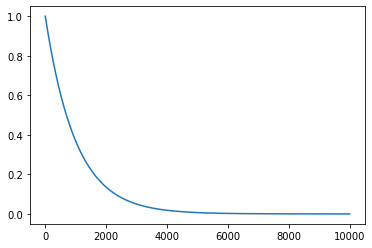

In [51]:
x = list(range(10000))
# print(x)
k = 1000
y = [float(np.exp(-i/k)) for i in x]
# print(y)
plt.plot(x,y)

In [ ]:
plt.plot(x_axis,epsilon_list)

In [ ]:
plt.plot(x_axis,rewards_list)

In [ ]:
plt.plot(x_axis,path_length_list)